In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
import numpy as np
import matplotlib.pyplot as plt
SMALL_SIZE = 25
MEDIUM_SIZE = 28
BIGGER_SIZE = 44
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIGGER_SIZE)  
%matplotlib inline
import seaborn as sns
import math
from math import sqrt
from tqdm import tqdm
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print(tensorflow.__version__)

2.8.2


In [5]:
dpath = "/content/drive/MyDrive/2022_물빅데이터공모전/데이터/"
df = pd.read_csv(dpath + 'data_jh_final.csv')
df['wqdt'][9] = '2019-01-10'
df['wqdt'][11] = '2019-01-12'
df['wqdt'][187] = '2019-07-07'
df["wqdt"] = pd.to_datetime(df["wqdt"])
df

,wqdt,bCod,bTn
0,2019-01-01,14.4,10.370
1,2019-01-02,14.0,10.181
2,2019-01-03,12.2,9.746
3,2019-01-04,12.6,8.880
4,2019-01-05,15.0,9.691
...,...,...,...
1030,2021-10-27,7.5,6.286
1031,2021-10-28,7.6,5.268
1032,2021-10-29,6.7,5.438
1033,2021-10-30,6.9,5.834


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   wqdt    1035 non-null   datetime64[ns]
 1   bCod    1035 non-null   float64       
 2   bTn     1035 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 24.4 KB


# bCod

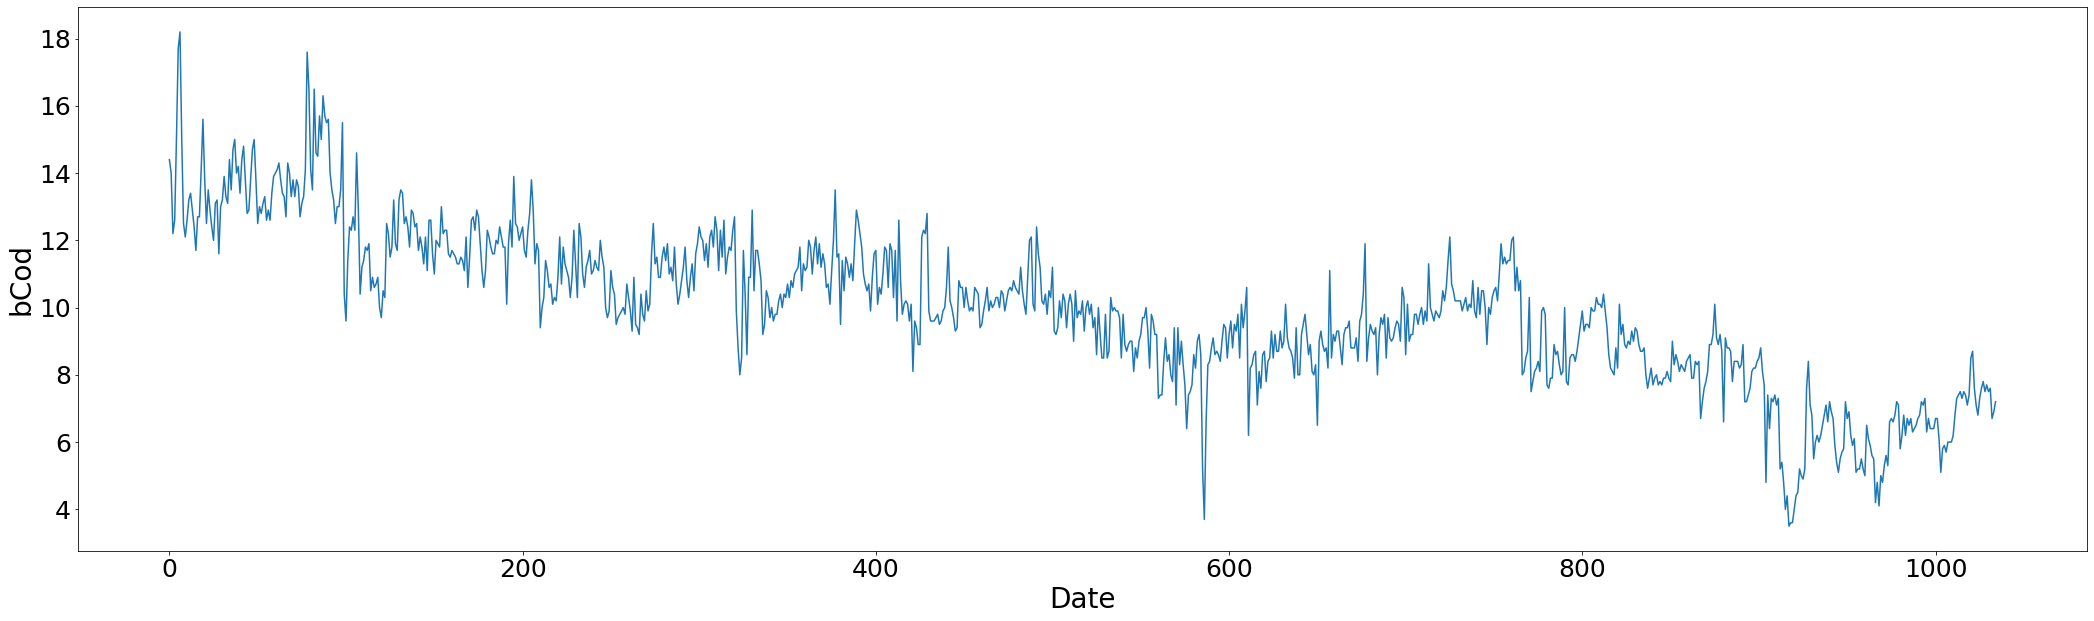

In [7]:
plt.figure(figsize=(36,10))
plt.plot(df.bCod)
plt.xlabel('Date')
plt.ylabel('bCod')
plt.show()

In [8]:
dataset = df.bCod.values
#dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [9]:
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [10]:
#Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

776 259


In [11]:
def creat_dataset(data, lagTerm=1):
    # create the dataset for later use.
    # lagTerm: How many previous timestemp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm -1):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 6
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [13]:
#reshape input into to be [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
# Set a valida set to avoid overfitting
validX = trainX[776:]
validY = trainY[776:]
trainX = trainX[:775]
trainY = trainY[:775]

## Model

In [15]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(1024, input_shape=(1,look_back),dropout=0.1, recurrent_dropout = 0.1)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

In [16]:
# Early stop callback function.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

In [17]:
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb])

Epoch 1/1000
25/25 - 5s - loss: 0.2005 - 5s/epoch - 200ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1058 - 244ms/epoch - 10ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0957 - 240ms/epoch - 10ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0985 - 221ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0908 - 241ms/epoch - 10ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0983 - 221ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0937 - 222ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0965 - 222ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0943 - 235ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0936 - 226ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0935 - 223ms/epoch - 9ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0957 - 239ms/epoch - 10ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0856 - 250ms/epoch - 10ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0961 - 230ms/epoch - 9ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0948 - 234ms/epoch - 9ms/step
Epoch 16/1000
25/25 - 0s - los

In [18]:
eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


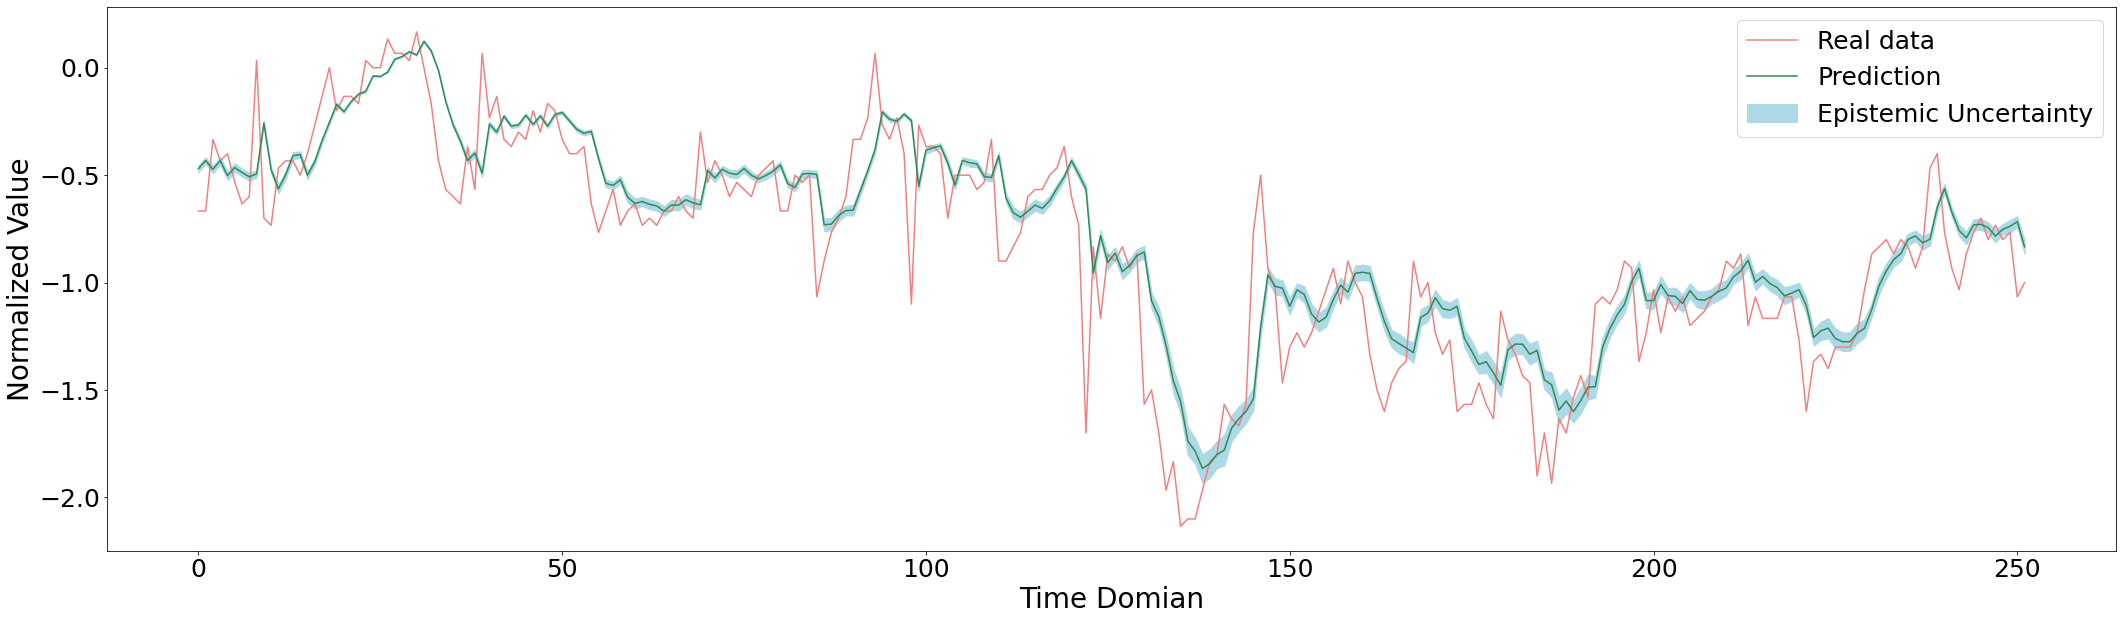

In [19]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*v**0.5, m + 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

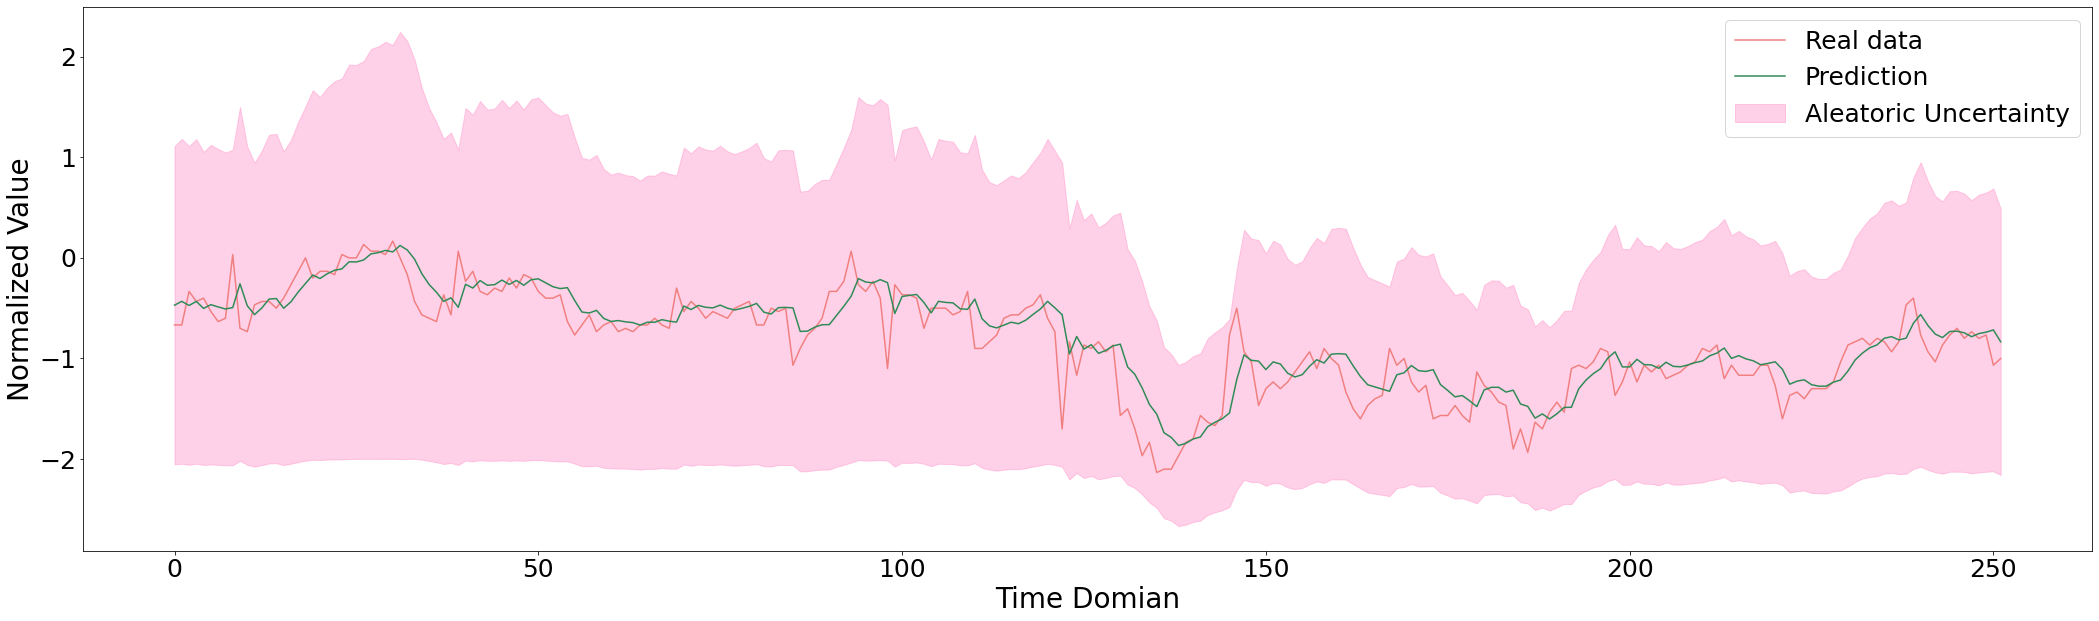

In [20]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*a_u**0.5, m + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

In [21]:
# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Test RMSE: 0.71 
Test MSE: 0.50 
Test r_squared: 0.77.


HyperParameter Tuning

In [22]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)




layer_range = [16,32,64,128,256,512]
dropout_range = [0.1,0.2,0.3]
recurrent_dropout_range = [0.1,0.2,0.3]

best_mse = 100
best_rmse = 0
best_r2 = 0 

for lay in layer_range:
    for drop in dropout_range:
        for recur in recurrent_dropout_range:
            theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],lay,drop,recur)

            eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
            ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
            eps = np.array(eps)
            ale = np.array(ale)
            m = np.mean(eps, axis=0).flatten() # predictive mean
            v = np.var(eps, axis=0).flatten() # epistemic uncertainty
            a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
            a_u = a_u.squeeze()
            v = v.squeeze()
            # Upper and lower bounds
            al_up = m + 2*a_u**0.5
            al_down = m - 2*a_u**0.5
            ep_up = m + 2*v**0.5
            ep_down = m - 2*v**0.5

            #reshape to (-1,1)
            trainY = trainY.reshape(-1,1)
            testY = testY.reshape(-1,1)
            m = m.reshape(-1,1)
            al_up = al_up.reshape(-1,1)
            al_down = al_down.reshape(-1,1)
            ep_up = ep_up.reshape(-1,1)
            ep_down = ep_down.reshape(-1,1)

            # invert predictions
            testPredict = scaler.inverse_transform(m)
            truth = scaler.inverse_transform(testY)
            epUp = scaler.inverse_transform(ep_up)
            epDown = scaler.inverse_transform(ep_down) 
            alUp = scaler.inverse_transform(al_up)
            alDown = scaler.inverse_transform(al_down)


            # RMSE
            testRScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
            #print('Test RMSE: %.2f ' % (testScore))

            # MSE
            testScore = mean_squared_error(truth[:,0], testPredict[:,0])
            #print('Test MSE: %.2f ' % (testScore))

            #r2
            r2 = r2_score(truth, testPredict)
            #print('Test r_squared: %.2f.' % (r2))

            if testScore <= best_mse:
                best_layer = lay
                best_dropout = drop
                best_recurrent_dropout = recur
                best_mse = testScore
                best_rmse = testRScore
                best_r2 = r2

            print("Layer = "+str(lay)+ " Dropout = "+str(drop)+" Recurrent_dropout = "+str(recur)+ 'Test RMSE: %.2f ' % (testRScore)+'Test MSE: %.2f ' % (testScore)+'Test r_squared: %.2f.' % (r2))

print("Best Layer = "+str(best_layer)+ "\nBest Dropout = "+str(best_dropout)+"\nRecurrent_dropout = "+str(best_recurrent_dropout)+ '\nTest RMSE: %.2f ' % (best_rmse)+'\nTest MSE: %.2f ' % (best_mse)+'\nTest r_squared: %.2f.' % (best_r2))


Epoch 1/1000
25/25 - 2s - loss: 0.3699 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2904 - 199ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2268 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1822 - 186ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1507 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1348 - 182ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1178 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1166 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1100 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1031 - 203ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1059 - 182ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1027 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1042 - 189ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0997 - 180ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1006 - 198ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.50it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.80 Test MSE: 3.25 Test r_squared: -0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.3190 - 2s/epoch - 97ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2297 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1739 - 187ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1437 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1246 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1173 - 192ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1093 - 194ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1082 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1073 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1089 - 189ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1058 - 187ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1039 - 177ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1048 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1006 - 201ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1037 - 187ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.52it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 1.42 Test MSE: 2.01 Test r_squared: 0.09.


Epoch 1/1000
25/25 - 2s - loss: 0.3848 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2825 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2061 - 193ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1598 - 183ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1372 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1214 - 205ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1104 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1119 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1110 - 197ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1037 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1012 - 186ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1031 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1007 - 198ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0999 - 213ms/epoch - 9ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1021 - 190ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:16<00:00,  6.09it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.26 Test MSE: 1.59 Test r_squared: 0.28.


Epoch 1/1000
25/25 - 3s - loss: 0.2930 - 3s/epoch - 101ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2134 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1629 - 181ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1366 - 212ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1230 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1172 - 181ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1143 - 185ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1100 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1102 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1042 - 343ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1108 - 347ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1066 - 465ms/epoch - 19ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1088 - 301ms/epoch - 12ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1075 - 424ms/epoch - 17ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1013 - 412ms/epoch - 16ms/step
Epoch 16/1000
25/25 - 0s - lo

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 1.69 Test MSE: 2.85 Test r_squared: -0.29.


Epoch 1/1000
25/25 - 2s - loss: 0.3327 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2430 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1791 - 184ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1517 - 193ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1341 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1244 - 198ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1232 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1134 - 197ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1116 - 208ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1144 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1157 - 177ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1076 - 186ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1098 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1097 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1111 - 195ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.75it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 1.56 Test MSE: 2.43 Test r_squared: -0.10.


Epoch 1/1000
25/25 - 2s - loss: 0.3428 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2666 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2115 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1714 - 200ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1429 - 190ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1374 - 192ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1244 - 183ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1176 - 191ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1242 - 181ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1159 - 195ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1124 - 204ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1119 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1099 - 204ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1062 - 188ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1072 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.44it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 1.75 Test MSE: 3.05 Test r_squared: -0.38.


Epoch 1/1000
25/25 - 2s - loss: 0.4307 - 2s/epoch - 99ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.3385 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2680 - 192ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.2147 - 183ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1736 - 213ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1478 - 189ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1418 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1383 - 193ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1273 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1167 - 196ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1213 - 190ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1169 - 208ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1255 - 217ms/epoch - 9ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1201 - 175ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1205 - 184ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 17.96it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.66 Test MSE: 2.77 Test r_squared: -0.25.


Epoch 1/1000
25/25 - 2s - loss: 0.4276 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.3432 - 201ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2678 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.2050 - 195ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1699 - 210ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1506 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1414 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1299 - 190ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1305 - 199ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1293 - 205ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1300 - 210ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1203 - 372ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 1s - loss: 0.1220 - 528ms/epoch - 21ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1173 - 385ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1183 - 358ms/epoch - 14ms/step
Epoch 16/1000
25/25 - 0s - loss:

100%|██████████| 100/100 [00:05<00:00, 18.37it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 1.53 Test MSE: 2.35 Test r_squared: -0.06.


Epoch 1/1000
25/25 - 3s - loss: 0.4000 - 3s/epoch - 102ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.3034 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.2228 - 203ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1698 - 200ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1552 - 217ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1363 - 190ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1310 - 196ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1298 - 216ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1230 - 203ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1247 - 195ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1247 - 199ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1183 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1143 - 209ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1134 - 197ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1138 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.56 Test MSE: 2.43 Test r_squared: -0.10.


Epoch 1/1000
25/25 - 2s - loss: 0.2670 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1630 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1266 - 183ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1139 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1055 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1080 - 182ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0984 - 207ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1006 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0976 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0965 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0983 - 185ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0956 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0983 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0957 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0989 - 200ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.44it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.28 Test MSE: 1.64 Test r_squared: 0.26.


Epoch 1/1000
25/25 - 3s - loss: 0.3244 - 3s/epoch - 102ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2002 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1339 - 207ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1138 - 216ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1102 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1062 - 187ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1036 - 201ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1012 - 192ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1013 - 188ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0976 - 196ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1001 - 179ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0955 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0955 - 181ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0944 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0965 - 187ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 17.51it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 1.28 Test MSE: 1.64 Test r_squared: 0.26.


Epoch 1/1000
25/25 - 2s - loss: 0.3627 - 2s/epoch - 93ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2451 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1711 - 205ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1287 - 204ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1150 - 206ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1092 - 197ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1090 - 205ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1048 - 211ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1011 - 198ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1045 - 191ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0981 - 205ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1000 - 196ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0982 - 207ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0975 - 198ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0968 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.23it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.53 Test MSE: 2.34 Test r_squared: -0.05.


Epoch 1/1000
25/25 - 3s - loss: 0.2878 - 3s/epoch - 103ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1827 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1329 - 192ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1177 - 196ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1107 - 206ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1084 - 201ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1106 - 193ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1082 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1090 - 178ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1035 - 183ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1060 - 192ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1048 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1016 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1054 - 194ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1030 - 181ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.32it/s]

Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 1.37 Test MSE: 1.89 Test r_squared: 0.15.


Epoch 1/1000
25/25 - 2s - loss: 0.3444 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2135 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1473 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1218 - 213ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1135 - 190ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1098 - 180ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1072 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1022 - 192ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1060 - 184ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1038 - 178ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1076 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1042 - 218ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1043 - 193ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1032 - 183ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0994 - 190ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 1.42 Test MSE: 2.01 Test r_squared: 0.09.
Epoch 1/1000
25/25 - 2s - loss: 0.3453 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2076 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1392 - 184ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1159 - 197ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1106 - 183ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1122 - 190ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1083 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1079 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1069 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1062 - 188ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1039 - 209ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1082 - 192ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1023 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1042 - 202ms/epoch - 8ms/step


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]

Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 1.31 Test MSE: 1.71 Test r_squared: 0.23.


Epoch 1/1000
25/25 - 2s - loss: 0.4356 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2947 - 197ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1915 - 187ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1519 - 194ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1337 - 202ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1298 - 184ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1228 - 204ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1271 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1087 - 198ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1208 - 188ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1185 - 184ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1062 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1218 - 198ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1096 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1077 - 188ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:06<00:00, 15.86it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.60 Test MSE: 2.56 Test r_squared: -0.16.


Epoch 1/1000
25/25 - 2s - loss: 0.3141 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1891 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1379 - 188ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1266 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1228 - 189ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1153 - 207ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1168 - 194ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1188 - 191ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1226 - 184ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1150 - 195ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1118 - 203ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1066 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1100 - 204ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1138 - 185ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1105 - 202ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.38it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 1.47 Test MSE: 2.17 Test r_squared: 0.02.


Epoch 1/1000
25/25 - 3s - loss: 0.2792 - 3s/epoch - 104ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1772 - 196ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1378 - 219ms/epoch - 9ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1282 - 194ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1230 - 219ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1176 - 211ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1088 - 204ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1123 - 198ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1108 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1105 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1085 - 200ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1083 - 194ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1105 - 199ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1146 - 185ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1116 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 17.97it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.48 Test MSE: 2.20 Test r_squared: 0.01.


Epoch 1/1000
25/25 - 2s - loss: 0.2825 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1501 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1085 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1043 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0971 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0987 - 198ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0936 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0930 - 196ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0914 - 201ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0981 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0976 - 203ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0923 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0918 - 201ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0871 - 186ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0970 - 186ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.54it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.21 Test MSE: 1.46 Test r_squared: 0.34.


Epoch 1/1000
25/25 - 3s - loss: 0.3203 - 3s/epoch - 104ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1613 - 185ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1121 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1050 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1012 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0988 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0967 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0964 - 211ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0957 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0917 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0911 - 188ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0913 - 185ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0972 - 186ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0891 - 202ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0924 - 192ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.28it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 1.16 Test MSE: 1.34 Test r_squared: 0.40.


Epoch 1/1000
25/25 - 2s - loss: 0.3044 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1564 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1121 - 183ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1026 - 188ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1054 - 203ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0996 - 191ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0949 - 192ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0949 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0964 - 185ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0945 - 180ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0957 - 194ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0956 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0943 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0947 - 182ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0953 - 197ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.21it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.14 Test MSE: 1.30 Test r_squared: 0.41.


Epoch 1/1000
25/25 - 3s - loss: 0.3091 - 3s/epoch - 103ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1602 - 192ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1213 - 202ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1097 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1097 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1136 - 185ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1057 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1093 - 199ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0999 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1068 - 193ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1052 - 192ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0989 - 196ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1019 - 195ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1014 - 182ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1004 - 193ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.42it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 1.26 Test MSE: 1.59 Test r_squared: 0.28.


Epoch 1/1000
25/25 - 2s - loss: 0.3355 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1804 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1204 - 202ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1157 - 197ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1070 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1171 - 184ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1115 - 202ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1038 - 197ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1071 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1007 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1042 - 200ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0984 - 192ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1000 - 211ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0947 - 186ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0985 - 179ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.53it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 1.32 Test MSE: 1.73 Test r_squared: 0.22.


Epoch 1/1000
25/25 - 3s - loss: 0.3681 - 3s/epoch - 102ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2046 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1346 - 196ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1154 - 184ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1100 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1101 - 197ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1076 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1038 - 185ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0980 - 184ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0994 - 189ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0950 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0973 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1014 - 204ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1022 - 189ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1037 - 185ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 1.37 Test MSE: 1.88 Test r_squared: 0.15.


Epoch 1/1000
25/25 - 2s - loss: 0.3016 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1582 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1298 - 209ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1162 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1158 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1053 - 223ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1147 - 211ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1146 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1110 - 181ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1105 - 216ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1196 - 184ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1076 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1060 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1156 - 208ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1134 - 201ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]

Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.45 Test MSE: 2.09 Test r_squared: 0.05.


Epoch 1/1000
25/25 - 3s - loss: 0.3410 - 3s/epoch - 103ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1813 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1197 - 193ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1167 - 215ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1123 - 180ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1183 - 192ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1060 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1096 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1096 - 181ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1134 - 208ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1104 - 182ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1146 - 185ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1052 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1134 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1031 - 206ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]

Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 1.41 Test MSE: 2.00 Test r_squared: 0.10.


Epoch 1/1000
25/25 - 2s - loss: 0.4196 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.2406 - 204ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1511 - 194ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1296 - 194ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1182 - 184ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1116 - 187ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1115 - 204ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1146 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1133 - 183ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1124 - 220ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1175 - 178ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1083 - 185ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0992 - 199ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1157 - 196ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1147 - 207ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.27it/s]

Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.38 Test MSE: 1.91 Test r_squared: 0.14.


Epoch 1/1000
25/25 - 2s - loss: 0.2869 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1261 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1067 - 201ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1038 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1006 - 201ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0963 - 190ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0980 - 199ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0932 - 190ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0922 - 208ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0972 - 201ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0924 - 186ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0888 - 186ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0879 - 189ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0931 - 194ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0882 - 196ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.01it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.87 Test MSE: 0.76 Test r_squared: 0.66.


Epoch 1/1000
25/25 - 2s - loss: 0.2959 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1255 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1036 - 191ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0981 - 186ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0906 - 190ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0904 - 199ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0959 - 191ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0954 - 185ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0941 - 182ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0950 - 186ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0896 - 211ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0910 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0879 - 189ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0907 - 188ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0896 - 183ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:06<00:00, 15.66it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.96 Test MSE: 0.93 Test r_squared: 0.58.


Epoch 1/1000
25/25 - 2s - loss: 0.2957 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1277 - 182ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1063 - 186ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1005 - 198ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0944 - 202ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1011 - 185ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0943 - 196ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0961 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0956 - 180ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0936 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0910 - 200ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0957 - 187ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0846 - 181ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0893 - 189ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0900 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 18.29it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.98 Test MSE: 0.96 Test r_squared: 0.57.


Epoch 1/1000
25/25 - 2s - loss: 0.2859 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1348 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1131 - 195ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1034 - 203ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1027 - 185ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0969 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1028 - 203ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1060 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0931 - 186ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1016 - 202ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0994 - 190ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1027 - 198ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1076 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0930 - 193ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1013 - 180ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.66it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 1.28 Test MSE: 1.65 Test r_squared: 0.26.


Epoch 1/1000
25/25 - 2s - loss: 0.3166 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1364 - 217ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1127 - 188ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1105 - 182ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0983 - 185ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1003 - 181ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1035 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1043 - 182ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1052 - 191ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0988 - 180ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0982 - 185ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1101 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1089 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1086 - 195ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1080 - 198ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.43it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 1.22 Test MSE: 1.49 Test r_squared: 0.32.


Epoch 1/1000
25/25 - 3s - loss: 0.3081 - 3s/epoch - 100ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1462 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1121 - 195ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1081 - 182ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1115 - 181ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1011 - 188ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1135 - 193ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1054 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0990 - 182ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0983 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1002 - 190ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0999 - 194ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1003 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1018 - 207ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1027 - 190ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 17.97it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 1.44 Test MSE: 2.06 Test r_squared: 0.07.


Epoch 1/1000
25/25 - 2s - loss: 0.2796 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1343 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1232 - 192ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1217 - 186ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1144 - 201ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1162 - 192ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1143 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1090 - 184ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1044 - 186ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1120 - 175ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1108 - 184ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1146 - 185ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1128 - 197ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1174 - 182ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1078 - 185ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.33it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.47 Test MSE: 2.16 Test r_squared: 0.03.


Epoch 1/1000
25/25 - 3s - loss: 0.3044 - 3s/epoch - 104ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1419 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1267 - 188ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1183 - 215ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1128 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1159 - 209ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1132 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1130 - 200ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1138 - 196ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1118 - 181ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1124 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1113 - 193ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1149 - 196ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1025 - 204ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1169 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.25it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 1.14 Test MSE: 1.31 Test r_squared: 0.41.


Epoch 1/1000
25/25 - 2s - loss: 0.3212 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1459 - 186ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1225 - 211ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1140 - 196ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1207 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1209 - 181ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1169 - 179ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1136 - 190ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1134 - 196ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1059 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1131 - 182ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1094 - 179ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1175 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1093 - 197ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1136 - 185ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.22it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.57 Test MSE: 2.46 Test r_squared: -0.11.


Epoch 1/1000
25/25 - 3s - loss: 0.2661 - 3s/epoch - 104ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1128 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1048 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1026 - 193ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1022 - 210ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0911 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0956 - 200ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0917 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0952 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0941 - 213ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0938 - 190ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0921 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1023 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0934 - 187ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0919 - 204ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:06<00:00, 16.59it/s]

Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.97 Test MSE: 0.93 Test r_squared: 0.58.


Epoch 1/1000
25/25 - 4s - loss: 0.2420 - 4s/epoch - 178ms/step
Epoch 2/1000
25/25 - 1s - loss: 0.1135 - 593ms/epoch - 24ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1007 - 415ms/epoch - 17ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0997 - 428ms/epoch - 17ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0900 - 400ms/epoch - 16ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0915 - 439ms/epoch - 18ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0908 - 443ms/epoch - 18ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0949 - 398ms/epoch - 16ms/step
Epoch 9/1000
25/25 - 1s - loss: 0.0901 - 718ms/epoch - 29ms/step
Epoch 10/1000
25/25 - 1s - loss: 0.0931 - 601ms/epoch - 24ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0963 - 494ms/epoch - 20ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0910 - 483ms/epoch - 19ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0900 - 486ms/epoch - 19ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0943 - 462ms/epoch - 18ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0928 - 444ms/epoch - 18ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.86 Test MSE: 0.73 Test r_squared: 0.67.
Epoch 1/1000
25/25 - 4s - loss: 0.2403 - 4s/epoch - 143ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1172 - 462ms/epoch - 18ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1038 - 272ms/epoch - 11ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0973 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0917 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0969 - 204ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0950 - 192ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0957 - 199ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0914 - 205ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0974 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0940 - 203ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0950 - 194ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0949 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0912 - 190ms/epoch - 8ms/s

100%|██████████| 100/100 [00:05<00:00, 17.89it/s]

Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.81 Test MSE: 0.65 Test r_squared: 0.70.


Epoch 1/1000
25/25 - 2s - loss: 0.2492 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1137 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1050 - 201ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1062 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1074 - 235ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1006 - 215ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0982 - 195ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1044 - 196ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0948 - 202ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1027 - 206ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1004 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1005 - 206ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0950 - 203ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0995 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1034 - 196ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:07<00:00, 13.48it/s]

Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.99 Test MSE: 0.97 Test r_squared: 0.56.


Epoch 1/1000
25/25 - 3s - loss: 0.2628 - 3s/epoch - 120ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1260 - 219ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1143 - 198ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1097 - 209ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1019 - 208ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1020 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1001 - 222ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0977 - 211ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1040 - 211ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1116 - 200ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1004 - 191ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0997 - 228ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1012 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1046 - 196ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1061 - 197ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 17.81it/s]


Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 1.23 Test MSE: 1.52 Test r_squared: 0.32.
Epoch 1/1000
25/25 - 2s - loss: 0.2463 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1232 - 196ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1081 - 211ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1100 - 194ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1108 - 202ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0983 - 196ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1014 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1075 - 199ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1010 - 192ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1028 - 190ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1014 - 206ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0981 - 224ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0970 - 196ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1007 - 197ms/epoch - 8ms/step

100%|██████████| 100/100 [00:05<00:00, 17.22it/s]

Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.90 Test MSE: 0.81 Test r_squared: 0.64.


Epoch 1/1000
25/25 - 2s - loss: 0.2499 - 2s/epoch - 91ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1309 - 203ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1251 - 204ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1074 - 227ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1118 - 201ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1214 - 219ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1216 - 218ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1111 - 206ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1058 - 213ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1079 - 198ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1131 - 188ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1135 - 196ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1139 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1157 - 209ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1130 - 197ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 17.93it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.33 Test MSE: 1.76 Test r_squared: 0.20.


Epoch 1/1000
25/25 - 2s - loss: 0.2537 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1229 - 193ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1126 - 203ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1167 - 191ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1191 - 317ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 1s - loss: 0.1181 - 525ms/epoch - 21ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1149 - 487ms/epoch - 19ms/step
Epoch 8/1000
25/25 - 1s - loss: 0.1105 - 657ms/epoch - 26ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1090 - 437ms/epoch - 17ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1124 - 465ms/epoch - 19ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1031 - 499ms/epoch - 20ms/step
Epoch 12/1000
25/25 - 1s - loss: 0.1096 - 581ms/epoch - 23ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1104 - 400ms/epoch - 16ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1105 - 431ms/epoch - 17ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1090 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s -

100%|██████████| 100/100 [00:09<00:00, 10.42it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 1.27 Test MSE: 1.61 Test r_squared: 0.27.


Epoch 1/1000
25/25 - 2s - loss: 0.2671 - 2s/epoch - 92ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1181 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1145 - 220ms/epoch - 9ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1191 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1168 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1119 - 195ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1143 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1162 - 206ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1104 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1069 - 198ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1199 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1172 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1147 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1136 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1122 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 18.40it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.51 Test MSE: 2.27 Test r_squared: -0.03.


Epoch 1/1000
25/25 - 2s - loss: 0.2127 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1043 - 196ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0967 - 204ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1062 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0944 - 206ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0965 - 196ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0940 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1023 - 215ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0916 - 219ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0926 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0917 - 208ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0948 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0990 - 206ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0879 - 205ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1026 - 215ms/epoch - 9ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.0

100%|██████████| 100/100 [00:05<00:00, 17.03it/s]

Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.10 Test MSE: 1.20 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 3s - loss: 0.2166 - 3s/epoch - 134ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1093 - 199ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0966 - 203ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0977 - 203ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0934 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1024 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0932 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0918 - 210ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0925 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0950 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0914 - 190ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0932 - 194ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0927 - 193ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0906 - 211ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0943 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.72 Test MSE: 0.52 Test r_squared: 0.76.
Epoch 1/1000
25/25 - 2s - loss: 0.2290 - 2s/epoch - 98ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1178 - 214ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0976 - 210ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0992 - 190ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0921 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0910 - 198ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0959 - 217ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0967 - 205ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0892 - 196ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0940 - 201ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0931 - 197ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0940 - 206ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0955 - 210ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0931 - 205ms/epoch - 8ms/step

100%|██████████| 100/100 [00:08<00:00, 11.54it/s]

Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.74.


Epoch 1/1000
25/25 - 3s - loss: 0.2133 - 3s/epoch - 115ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1159 - 248ms/epoch - 10ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1078 - 392ms/epoch - 16ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0988 - 474ms/epoch - 19ms/step
Epoch 5/1000
25/25 - 1s - loss: 0.1028 - 542ms/epoch - 22ms/step
Epoch 6/1000
25/25 - 1s - loss: 0.1015 - 511ms/epoch - 20ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1030 - 469ms/epoch - 19ms/step
Epoch 8/1000
25/25 - 1s - loss: 0.1013 - 517ms/epoch - 21ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1127 - 214ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1076 - 228ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1029 - 317ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1007 - 469ms/epoch - 19ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1033 - 277ms/epoch - 11ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1136 - 447ms/epoch - 18ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1075 - 340ms/epoch - 14ms/step
Epoch 16/1000
25/25 - 0

100%|██████████| 100/100 [00:06<00:00, 14.75it/s]

Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 1.42 Test MSE: 2.00 Test r_squared: 0.10.


Epoch 1/1000
25/25 - 5s - loss: 0.1989 - 5s/epoch - 204ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1195 - 374ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1057 - 451ms/epoch - 18ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1082 - 400ms/epoch - 16ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0978 - 458ms/epoch - 18ms/step
Epoch 6/1000
25/25 - 1s - loss: 0.1054 - 511ms/epoch - 20ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1053 - 497ms/epoch - 20ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1008 - 234ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1026 - 192ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0981 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0957 - 202ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0986 - 219ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1002 - 221ms/epoch - 9ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1022 - 209ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1044 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - lo

100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.73.
Epoch 1/1000
25/25 - 2s - loss: 0.2091 - 2s/epoch - 90ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1107 - 214ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1074 - 198ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1048 - 206ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0968 - 206ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1008 - 204ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1014 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1029 - 191ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1113 - 220ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1027 - 368ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0999 - 426ms/epoch - 17ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1037 - 324ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1009 - 439ms/epoch - 18ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0995 - 394ms/epoch - 16ms

100%|██████████| 100/100 [00:05<00:00, 18.01it/s]

Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.97 Test MSE: 0.94 Test r_squared: 0.58.


Epoch 1/1000
25/25 - 2s - loss: 0.2185 - 2s/epoch - 99ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1190 - 211ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1214 - 192ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1160 - 215ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1234 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1144 - 198ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1189 - 199ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1251 - 216ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1242 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1160 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1143 - 197ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1102 - 194ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1132 - 220ms/epoch - 9ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1213 - 195ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1023 - 195ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.1

100%|██████████| 100/100 [00:05<00:00, 16.78it/s]


Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.97 Test MSE: 0.94 Test r_squared: 0.57.
Epoch 1/1000
25/25 - 5s - loss: 0.2231 - 5s/epoch - 189ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1274 - 206ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1116 - 205ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1067 - 209ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1179 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1128 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1207 - 202ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1035 - 198ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1165 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1114 - 203ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1071 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1077 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1088 - 202ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1197 - 205ms/epoch - 8ms/ste

100%|██████████| 100/100 [00:11<00:00,  8.90it/s]

Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.78 Test MSE: 0.60 Test r_squared: 0.73.


Epoch 1/1000
25/25 - 4s - loss: 0.2094 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1287 - 414ms/epoch - 17ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1129 - 380ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1092 - 445ms/epoch - 18ms/step
Epoch 5/1000
25/25 - 1s - loss: 0.1122 - 546ms/epoch - 22ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1188 - 413ms/epoch - 17ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1149 - 428ms/epoch - 17ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1189 - 422ms/epoch - 17ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1124 - 435ms/epoch - 17ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1084 - 380ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1164 - 426ms/epoch - 17ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1168 - 454ms/epoch - 18ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1175 - 434ms/epoch - 17ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1151 - 400ms/epoch - 16ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1057 - 212ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 

100%|██████████| 100/100 [00:05<00:00, 18.16it/s]

Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.19 Test MSE: 1.42 Test r_squared: 0.36.
Best Layer = 512
Best Dropout = 0.1
Recurrent_dropout = 0.2
Test RMSE: 0.72 
Test MSE: 0.52 
Test r_squared: 0.76.


In [39]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],best_layer,best_dropout,best_recurrent_dropout)

eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

print()
# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Epoch 1/1000
25/25 - 3s - loss: 0.2244 - 3s/epoch - 102ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1137 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0998 - 205ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0974 - 217ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0961 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0947 - 212ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0941 - 207ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0936 - 221ms/epoch - 9ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0922 - 209ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0900 - 216ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0937 - 208ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0930 - 200ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0998 - 212ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0923 - 194ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0900 - 207ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.22it/s]


Test RMSE: 0.74 
Test MSE: 0.55 
Test r_squared: 0.75.


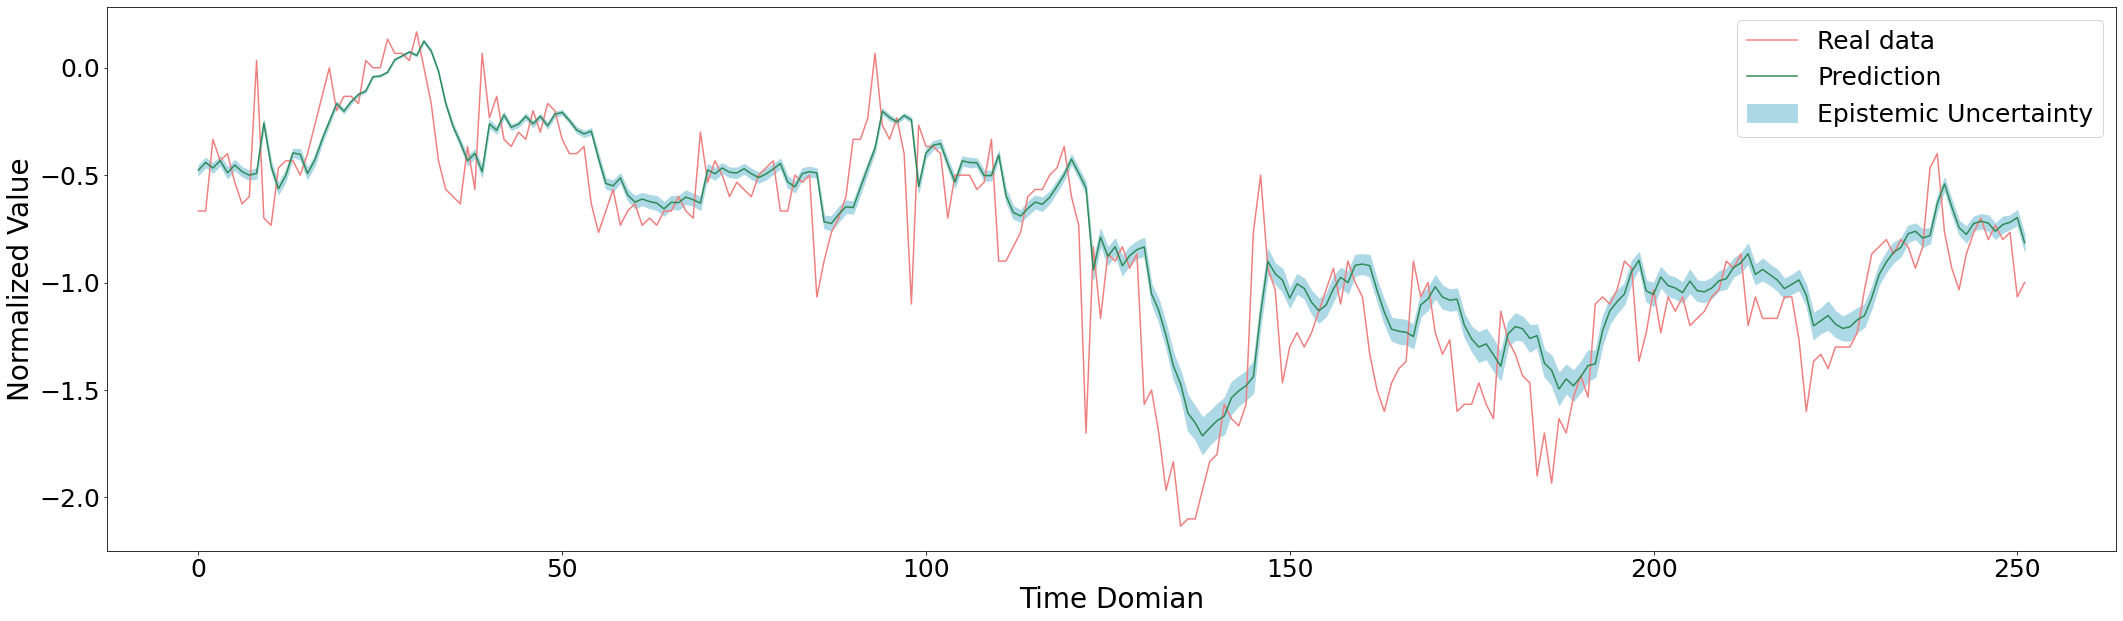

In [40]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() + 2*v**0.5, np.mean(eps, axis=0).flatten() - 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

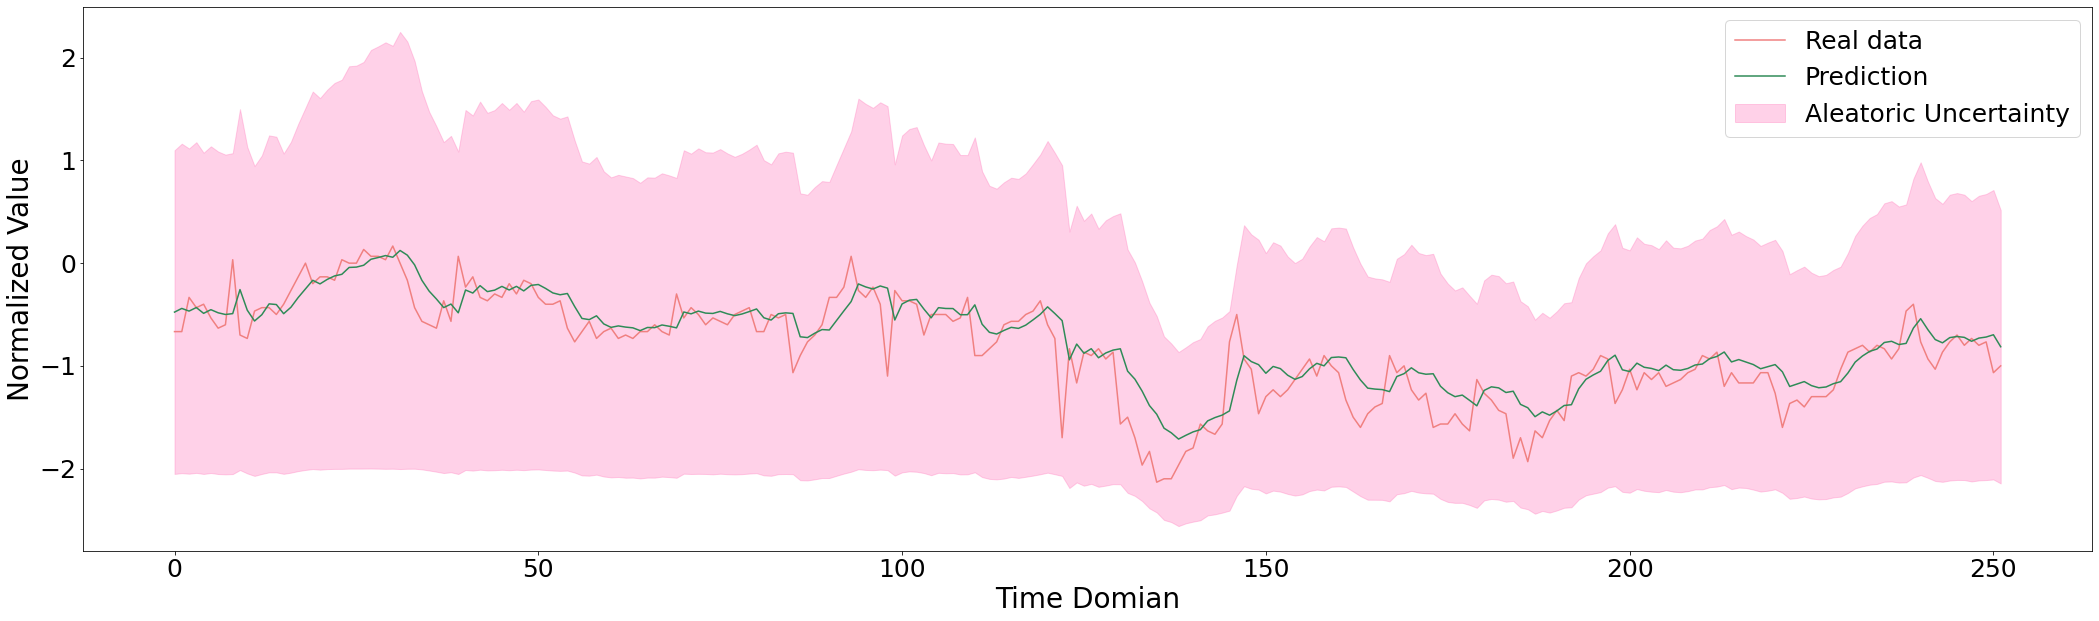

In [41]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() - 2*a_u**0.5, np.mean(eps, axis=0).flatten() + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

hyper 2 

In [42]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay1,lay2,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay1, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur,return_sequences=True)(x)
    x = LSTM(lay2, dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)




layer1_range = [128,256,512]
layer2_range = [32,64,128]

dropout_range = [0.1,0.3]
recurrent_dropout_range = [0.1,0.3]

best_mse = 100
best_rmse = 0
best_r2 = 0 

for lay1 in layer1_range:
    for lay2 in layer2_range:
        for drop in dropout_range:
            for recur in recurrent_dropout_range:
                theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],lay1,lay2,drop,recur)

                eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
                ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
                eps = np.array(eps)
                ale = np.array(ale)
                m = np.mean(eps, axis=0).flatten() # predictive mean
                v = np.var(eps, axis=0).flatten() # epistemic uncertainty
                a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
                a_u = a_u.squeeze()
                v = v.squeeze()
                # Upper and lower bounds
                al_up = m + 2*a_u**0.5
                al_down = m - 2*a_u**0.5
                ep_up = m + 2*v**0.5
                ep_down = m - 2*v**0.5

                #reshape to (-1,1)
                trainY = trainY.reshape(-1,1)
                testY = testY.reshape(-1,1)
                m = m.reshape(-1,1)
                al_up = al_up.reshape(-1,1)
                al_down = al_down.reshape(-1,1)
                ep_up = ep_up.reshape(-1,1)
                ep_down = ep_down.reshape(-1,1)

                # invert predictions
                testPredict = scaler.inverse_transform(m)
                truth = scaler.inverse_transform(testY)
                epUp = scaler.inverse_transform(ep_up)
                epDown = scaler.inverse_transform(ep_down) 
                alUp = scaler.inverse_transform(al_up)
                alDown = scaler.inverse_transform(al_down)


                # RMSE
                testRScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
                #print('Test RMSE: %.2f ' % (testScore))

                # MSE
                testScore = mean_squared_error(truth[:,0], testPredict[:,0])
                #print('Test MSE: %.2f ' % (testScore))

                #r2
                r2 = r2_score(truth, testPredict)
                #print('Test r_squared: %.2f.' % (r2))

                if testScore <= best_mse:
                    best_layer1 = lay1
                    best_layer2 = lay2
                    best_dropout = drop
                    best_recurrent_dropout = recur
                    best_mse = testScore
                    best_rmse = testRScore
                    best_r2 = r2

                print("Layer1 = "+str(lay1)+"Layer2 = "+str(lay2)+ " Dropout = "+str(drop)+" Recurrent_dropout = "+str(recur)+ 'Test RMSE: %.2f ' % (testRScore)+'Test MSE: %.2f ' % (testScore)+'Test r_squared: %.2f.' % (r2))

print("Best Layer1 = "+str(best_layer1)+"Best Layer2 = "+str(best_layer2)+ "\nBest Dropout = "+str(best_dropout)+"\nRecurrent_dropout = "+str(best_recurrent_dropout)+ '\nTest RMSE: %.2f ' % (best_rmse)+'\nTest MSE: %.2f ' % (best_mse)+'\nTest r_squared: %.2f.' % (best_r2))

Epoch 1/1000
25/25 - 8s - loss: 0.3336 - 8s/epoch - 311ms/step
Epoch 2/1000
25/25 - 1s - loss: 0.1453 - 1s/epoch - 56ms/step
Epoch 3/1000
25/25 - 1s - loss: 0.1124 - 1s/epoch - 43ms/step
Epoch 4/1000
25/25 - 1s - loss: 0.1013 - 1s/epoch - 56ms/step
Epoch 5/1000
25/25 - 1s - loss: 0.0993 - 1s/epoch - 53ms/step
Epoch 6/1000
25/25 - 1s - loss: 0.0962 - 1s/epoch - 42ms/step
Epoch 7/1000
25/25 - 1s - loss: 0.0952 - 844ms/epoch - 34ms/step
Epoch 8/1000
25/25 - 1s - loss: 0.0963 - 720ms/epoch - 29ms/step
Epoch 9/1000
25/25 - 1s - loss: 0.0972 - 829ms/epoch - 33ms/step
Epoch 10/1000
25/25 - 1s - loss: 0.0905 - 838ms/epoch - 34ms/step
Epoch 11/1000
25/25 - 1s - loss: 0.0960 - 795ms/epoch - 32ms/step
Epoch 12/1000
25/25 - 1s - loss: 0.0966 - 971ms/epoch - 39ms/step
Epoch 13/1000
25/25 - 1s - loss: 0.0929 - 1s/epoch - 47ms/step
Epoch 14/1000
25/25 - 1s - loss: 0.0916 - 1s/epoch - 44ms/step
Epoch 15/1000
25/25 - 1s - loss: 0.0921 - 1s/epoch - 48ms/step
Epoch 16/1000
25/25 - 1s - loss: 0.0898 - 1s/

100%|██████████| 100/100 [00:05<00:00, 17.20it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.19 Test MSE: 1.41 Test r_squared: 0.36.


Epoch 1/1000
25/25 - 4s - loss: 0.3469 - 4s/epoch - 167ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1588 - 354ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1157 - 340ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1074 - 354ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1038 - 372ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1005 - 339ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0959 - 351ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1000 - 343ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0931 - 336ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0969 - 342ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0931 - 358ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0894 - 352ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0918 - 346ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0942 - 345ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0976 - 358ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


Layer1 = 128Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.43 Test MSE: 2.05 Test r_squared: 0.07.
Epoch 1/1000
25/25 - 4s - loss: 0.3533 - 4s/epoch - 173ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1658 - 334ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1227 - 349ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1246 - 335ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1202 - 345ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1207 - 355ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1210 - 338ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1118 - 349ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1140 - 351ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1132 - 325ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1148 - 344ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1103 - 361ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1206 - 336ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1049

100%|██████████| 100/100 [00:05<00:00, 17.17it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.42 Test MSE: 2.02 Test r_squared: 0.09.


Epoch 1/1000
25/25 - 5s - loss: 0.3508 - 5s/epoch - 189ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1824 - 336ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1273 - 355ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1173 - 346ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1241 - 344ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1087 - 341ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1099 - 335ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1139 - 354ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1092 - 340ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1044 - 336ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1104 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1058 - 343ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1189 - 353ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1182 - 345ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1128 - 353ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.24it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.38 Test MSE: 1.90 Test r_squared: 0.14.


Epoch 1/1000
25/25 - 4s - loss: 0.3287 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1349 - 362ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1129 - 339ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1023 - 344ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0929 - 343ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0926 - 340ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0915 - 334ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0972 - 350ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0963 - 345ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0923 - 336ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0905 - 356ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0929 - 375ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0929 - 329ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0908 - 351ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0958 - 345ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.34it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.17 Test MSE: 1.38 Test r_squared: 0.38.


Epoch 1/1000
25/25 - 4s - loss: 0.3041 - 4s/epoch - 173ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1216 - 345ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1036 - 347ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0938 - 345ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0964 - 366ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0950 - 338ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0917 - 359ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0920 - 339ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0960 - 344ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0948 - 354ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0934 - 340ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0916 - 359ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1036 - 357ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0903 - 338ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0927 - 333ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.32it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.09 Test MSE: 1.18 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 5s - loss: 0.3332 - 5s/epoch - 188ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1503 - 366ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1266 - 343ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1253 - 341ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1151 - 351ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1049 - 349ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1095 - 347ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1106 - 353ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1161 - 330ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1105 - 334ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1058 - 337ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1151 - 340ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1076 - 356ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1057 - 359ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1127 - 349ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.65it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.40 Test MSE: 1.95 Test r_squared: 0.12.


Epoch 1/1000
25/25 - 5s - loss: 0.3246 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1396 - 358ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1200 - 351ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1236 - 346ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1120 - 342ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1162 - 347ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1060 - 364ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1110 - 352ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1077 - 333ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1072 - 361ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1111 - 329ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1029 - 344ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1103 - 339ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1117 - 339ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1071 - 362ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.27it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.35 Test MSE: 1.83 Test r_squared: 0.17.


Epoch 1/1000
25/25 - 4s - loss: 0.2913 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1287 - 328ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1041 - 337ms/epoch - 13ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0967 - 347ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0949 - 339ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0916 - 345ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0994 - 333ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0951 - 333ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0983 - 334ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0950 - 341ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0919 - 348ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0940 - 381ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0920 - 362ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0934 - 328ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0914 - 346ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.28it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.99 Test MSE: 0.99 Test r_squared: 0.55.


Epoch 1/1000
25/25 - 4s - loss: 0.2979 - 4s/epoch - 172ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1162 - 334ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1025 - 351ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0955 - 357ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0932 - 339ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0945 - 353ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0960 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0936 - 334ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0927 - 354ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0896 - 338ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0971 - 339ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0945 - 356ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0939 - 355ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0913 - 343ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0922 - 345ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.71it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.05 Test MSE: 1.10 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 5s - loss: 0.3195 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1333 - 357ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1196 - 344ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1190 - 376ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1110 - 351ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1136 - 341ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1101 - 355ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1138 - 337ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1186 - 347ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0998 - 366ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1105 - 348ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1094 - 349ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1106 - 370ms/epoch - 15ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1133 - 344ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1076 - 334ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.52it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.12 Test MSE: 1.26 Test r_squared: 0.43.


Epoch 1/1000
25/25 - 5s - loss: 0.2998 - 5s/epoch - 189ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1259 - 361ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1136 - 330ms/epoch - 13ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1227 - 363ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1188 - 345ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1062 - 346ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1136 - 356ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1109 - 362ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1154 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1124 - 347ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1184 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1175 - 364ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1153 - 362ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1118 - 394ms/epoch - 16ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1101 - 338ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.36it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.28 Test MSE: 1.64 Test r_squared: 0.26.


Epoch 1/1000
25/25 - 4s - loss: 0.2875 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1223 - 356ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1068 - 367ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0987 - 358ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0957 - 364ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0948 - 372ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0950 - 375ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0955 - 355ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0902 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0935 - 345ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0959 - 355ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0912 - 348ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0941 - 354ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0926 - 368ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0963 - 363ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.05it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.33 Test MSE: 1.78 Test r_squared: 0.20.


Epoch 1/1000
25/25 - 4s - loss: 0.3090 - 4s/epoch - 173ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1223 - 363ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1034 - 371ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1020 - 362ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0981 - 353ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0973 - 360ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0946 - 355ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0939 - 364ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0989 - 359ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0943 - 352ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0966 - 346ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0969 - 373ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0944 - 347ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0898 - 344ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0963 - 359ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.54it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.21 Test MSE: 1.47 Test r_squared: 0.34.


Epoch 1/1000
25/25 - 5s - loss: 0.3283 - 5s/epoch - 189ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1509 - 385ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1275 - 377ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1190 - 350ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1162 - 337ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1156 - 359ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1189 - 352ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1185 - 345ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1088 - 360ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1084 - 360ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1050 - 350ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1120 - 350ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1094 - 358ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1140 - 356ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1066 - 354ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.33it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.22 Test MSE: 1.48 Test r_squared: 0.33.


Epoch 1/1000
25/25 - 5s - loss: 0.3102 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1299 - 375ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1189 - 358ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1153 - 365ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1147 - 376ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1147 - 349ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1097 - 360ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1143 - 379ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1178 - 360ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1100 - 348ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1128 - 374ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1116 - 351ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1178 - 347ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1088 - 365ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1119 - 347ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.93it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.49 Test MSE: 2.23 Test r_squared: -0.01.


Epoch 1/1000
25/25 - 4s - loss: 0.2736 - 4s/epoch - 168ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1168 - 342ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1025 - 362ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1002 - 353ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0952 - 354ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0974 - 364ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0972 - 355ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0898 - 362ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0927 - 353ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0875 - 351ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0906 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0922 - 356ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0901 - 360ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0923 - 358ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0966 - 336ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.15 Test MSE: 1.33 Test r_squared: 0.40.


Epoch 1/1000
25/25 - 4s - loss: 0.2795 - 4s/epoch - 174ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1109 - 352ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0981 - 347ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0930 - 350ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1001 - 340ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0968 - 347ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0907 - 371ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0897 - 356ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0934 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0925 - 355ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0887 - 343ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0943 - 340ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0935 - 354ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0899 - 342ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0915 - 366ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.65it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.10 Test MSE: 1.22 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 5s - loss: 0.2636 - 5s/epoch - 188ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1189 - 360ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1128 - 353ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1171 - 347ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1118 - 363ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1098 - 341ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1115 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1107 - 363ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1186 - 352ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1101 - 345ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1072 - 355ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1033 - 358ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1070 - 347ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1088 - 353ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1066 - 347ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.98it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.32 Test MSE: 1.74 Test r_squared: 0.22.


Epoch 1/1000
25/25 - 5s - loss: 0.2940 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1247 - 374ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1209 - 361ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1089 - 350ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1092 - 368ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1187 - 344ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1118 - 343ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1117 - 347ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1155 - 354ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1166 - 356ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1138 - 366ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1108 - 353ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1133 - 361ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1146 - 342ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1137 - 351ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.15it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.40 Test MSE: 1.97 Test r_squared: 0.11.


Epoch 1/1000
25/25 - 4s - loss: 0.2395 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1170 - 368ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1000 - 354ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0963 - 345ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0915 - 359ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0986 - 351ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0911 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0962 - 358ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0964 - 351ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0979 - 343ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0926 - 361ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0915 - 335ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0983 - 342ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0928 - 344ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0934 - 337ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.47it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.06 Test MSE: 1.12 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 4s - loss: 0.2672 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1287 - 348ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1030 - 360ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0923 - 357ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0922 - 357ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0953 - 346ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0897 - 362ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0940 - 331ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0882 - 345ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0975 - 350ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0907 - 339ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0894 - 363ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0882 - 346ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0941 - 342ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0891 - 334ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.05it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.18 Test MSE: 1.40 Test r_squared: 0.37.


Epoch 1/1000
25/25 - 5s - loss: 0.2543 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1337 - 355ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1175 - 341ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1203 - 365ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1202 - 361ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1150 - 337ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1104 - 357ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1100 - 347ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1180 - 342ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1146 - 348ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1139 - 342ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1138 - 328ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1039 - 357ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1086 - 352ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1206 - 356ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Layer1 = 256Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.45 Test MSE: 2.09 Test r_squared: 0.06.
Epoch 1/1000
25/25 - 5s - loss: 0.2710 - 5s/epoch - 185ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1330 - 357ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1162 - 366ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1184 - 336ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1178 - 352ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1071 - 365ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1161 - 345ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1116 - 360ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1106 - 353ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1019 - 354ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1098 - 343ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1048 - 373ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1104 - 351ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.105

100%|██████████| 100/100 [00:05<00:00, 17.51it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.05 Test MSE: 1.10 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 4s - loss: 0.2471 - 4s/epoch - 168ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1171 - 345ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1038 - 352ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1075 - 360ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0956 - 340ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0961 - 336ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0940 - 356ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0967 - 344ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0885 - 367ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0991 - 364ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0992 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1056 - 371ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0978 - 340ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0921 - 344ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0931 - 346ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.89it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 1.32 Test MSE: 1.75 Test r_squared: 0.21.


Epoch 1/1000
25/25 - 4s - loss: 0.2561 - 4s/epoch - 172ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1185 - 361ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1013 - 356ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0980 - 366ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0942 - 348ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0991 - 355ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0947 - 363ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0984 - 347ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0924 - 358ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0964 - 349ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0972 - 341ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0992 - 349ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0933 - 334ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0945 - 334ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0963 - 360ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.40it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.43 Test MSE: 2.06 Test r_squared: 0.07.


Epoch 1/1000
25/25 - 5s - loss: 0.2842 - 5s/epoch - 185ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1271 - 372ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1133 - 369ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1051 - 343ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1091 - 354ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1207 - 338ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1197 - 336ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1105 - 361ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1171 - 336ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1201 - 343ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1112 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1088 - 344ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1110 - 340ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1183 - 348ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1131 - 341ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.25it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.50 Test MSE: 2.26 Test r_squared: -0.02.


Epoch 1/1000
25/25 - 5s - loss: 0.2637 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1338 - 357ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1180 - 342ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1050 - 343ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1192 - 355ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1143 - 343ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1100 - 344ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1111 - 354ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1005 - 365ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1113 - 353ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1125 - 364ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1088 - 334ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1065 - 347ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1138 - 356ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1109 - 347ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.47it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.22 Test MSE: 1.49 Test r_squared: 0.33.


Epoch 1/1000
25/25 - 4s - loss: 0.2395 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1167 - 363ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1002 - 355ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0941 - 380ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0905 - 355ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0924 - 346ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0933 - 370ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0919 - 348ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0896 - 361ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0920 - 346ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0947 - 349ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0962 - 356ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0928 - 341ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0945 - 345ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0918 - 367ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 15.90it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.95 Test MSE: 0.90 Test r_squared: 0.59.


Epoch 1/1000
25/25 - 4s - loss: 0.2311 - 4s/epoch - 172ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1057 - 357ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0964 - 361ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0933 - 357ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0938 - 374ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0975 - 338ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1002 - 359ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0896 - 378ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0944 - 332ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0955 - 341ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0909 - 346ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0941 - 343ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0900 - 354ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0890 - 353ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0928 - 359ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.31it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.15 Test MSE: 1.33 Test r_squared: 0.40.


Epoch 1/1000
25/25 - 5s - loss: 0.2423 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1271 - 356ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1101 - 353ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1143 - 362ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1204 - 351ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1183 - 345ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1109 - 348ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1112 - 352ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1127 - 357ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1126 - 368ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1128 - 351ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1110 - 345ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1132 - 345ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1185 - 338ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1132 - 346ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.63it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.43 Test MSE: 2.05 Test r_squared: 0.08.


Epoch 1/1000
25/25 - 5s - loss: 0.2467 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1355 - 361ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1100 - 358ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1225 - 351ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1055 - 347ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1072 - 361ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1123 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1181 - 356ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1138 - 346ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1090 - 344ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1163 - 366ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1052 - 356ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1125 - 334ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1069 - 348ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1074 - 344ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.12it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.50 Test MSE: 2.25 Test r_squared: -0.01.


Epoch 1/1000
25/25 - 4s - loss: 0.2113 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1091 - 365ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0939 - 354ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0909 - 367ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0922 - 378ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0922 - 340ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0910 - 362ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0929 - 373ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1015 - 349ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0991 - 345ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0949 - 370ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0903 - 368ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0901 - 362ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0888 - 356ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0982 - 354ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.19it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.93 Test MSE: 0.86 Test r_squared: 0.61.


Epoch 1/1000
25/25 - 5s - loss: 0.2281 - 5s/epoch - 192ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1045 - 368ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0978 - 380ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0931 - 357ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0959 - 364ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0962 - 362ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0902 - 363ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0929 - 351ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0879 - 367ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0973 - 351ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.0901 - 340ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0902 - 363ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0988 - 347ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0923 - 363ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0958 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.86it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 1.04 Test MSE: 1.08 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 5s - loss: 0.2561 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1258 - 355ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1109 - 352ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1035 - 376ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1089 - 345ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1141 - 358ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1136 - 352ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1048 - 335ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1026 - 365ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1063 - 376ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1219 - 342ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1100 - 338ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1102 - 351ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1065 - 361ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1091 - 343ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 15.94it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 1.23 Test MSE: 1.50 Test r_squared: 0.32.


Epoch 1/1000
25/25 - 4s - loss: 0.2392 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1196 - 386ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.1171 - 356ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.1197 - 344ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.1167 - 354ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.1064 - 367ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.1166 - 355ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.1138 - 339ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.1158 - 337ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.1082 - 368ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1058 - 353ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.1185 - 358ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.1062 - 373ms/epoch - 15ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.1023 - 365ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.1055 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.72it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 1.63 Test MSE: 2.66 Test r_squared: -0.20.
Best Layer1 = 512Best Layer2 = 128
Best Dropout = 0.1
Recurrent_dropout = 0.1
Test RMSE: 0.93 
Test MSE: 0.86 
Test r_squared: 0.61.


In [43]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay1,lay2,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay1, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur,return_sequences=True)(x)
    x = LSTM(lay2, dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],best_layer1,best_layer2,best_dropout,best_recurrent_dropout)

eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

print()
# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Epoch 1/1000
25/25 - 4s - loss: 0.2307 - 4s/epoch - 175ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.1119 - 363ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.0966 - 353ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.0955 - 366ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.0960 - 342ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.0939 - 363ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.0938 - 391ms/epoch - 16ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.0914 - 349ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.0938 - 351ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.0957 - 355ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.1004 - 351ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.0938 - 344ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.0896 - 369ms/epoch - 15ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.0919 - 377ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.0908 - 369ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


Test RMSE: 0.83 
Test MSE: 0.69 
Test r_squared: 0.69.


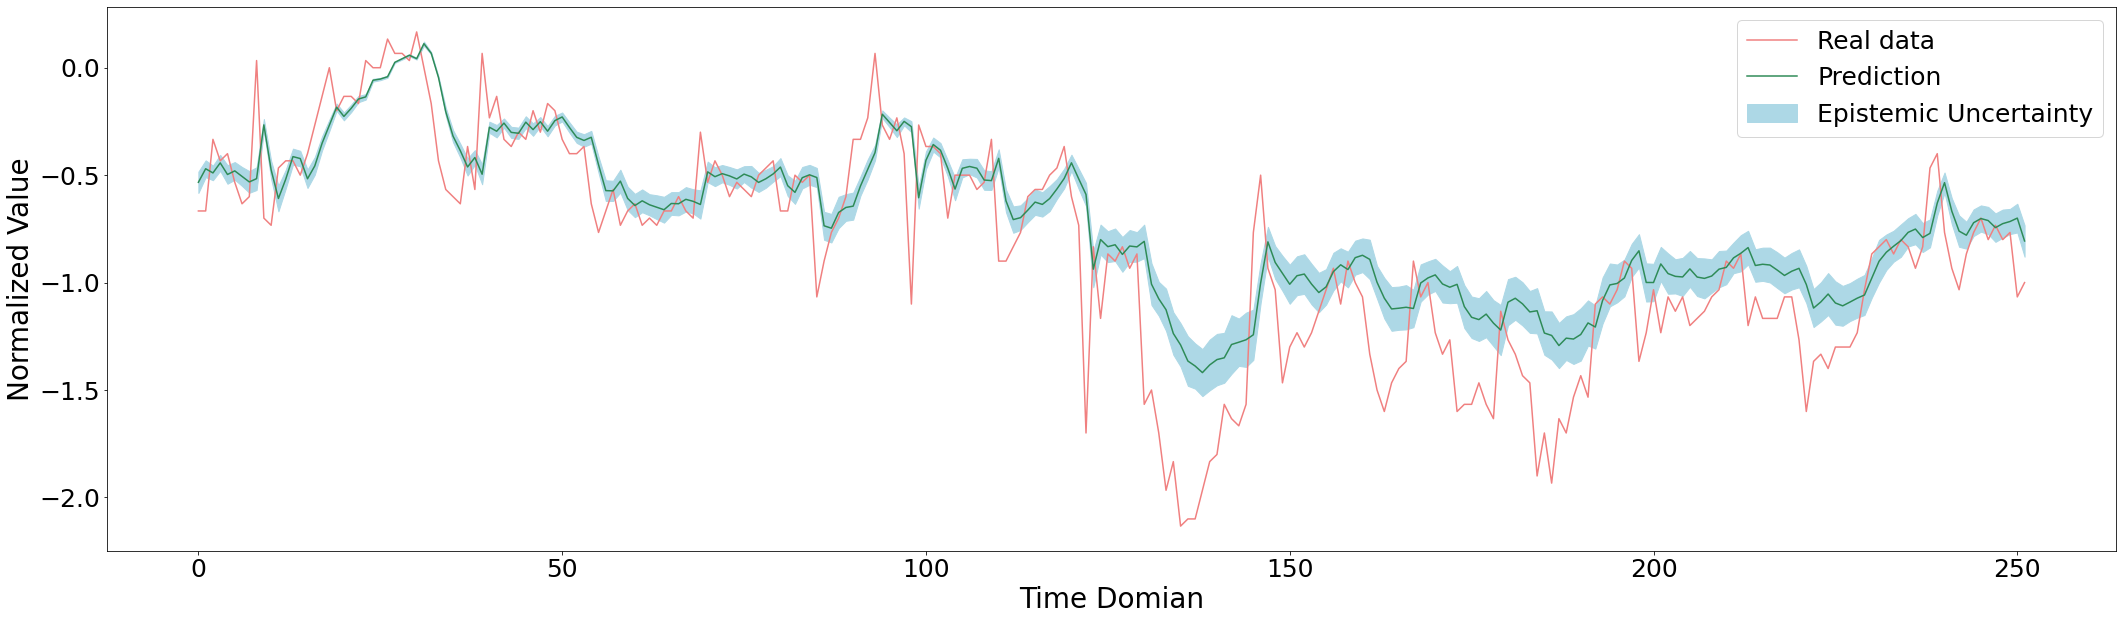

In [44]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() + 2*v**0.5, np.mean(eps, axis=0).flatten() - 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

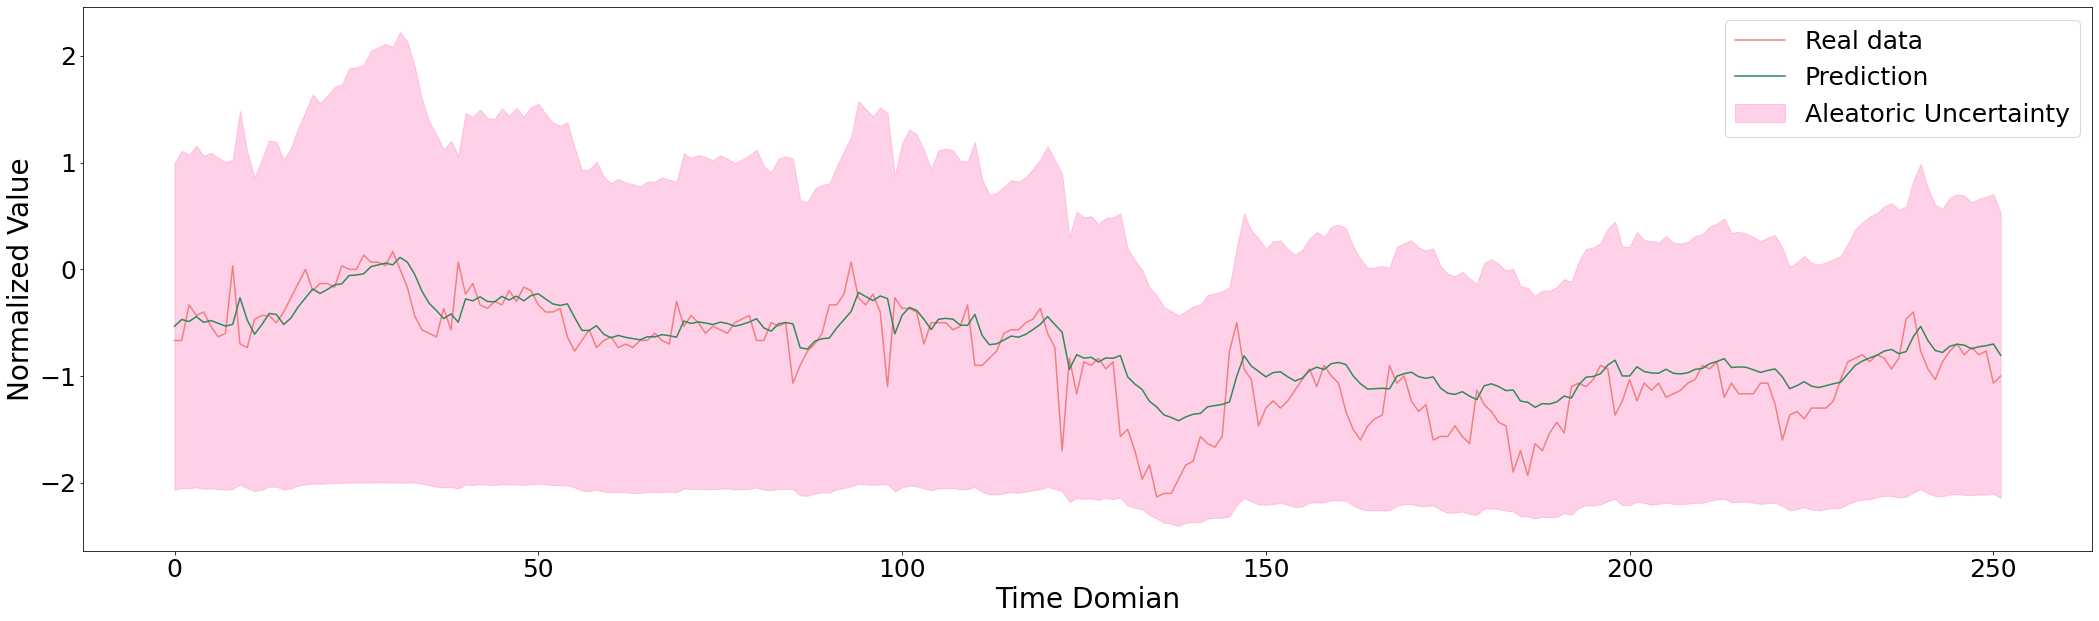

In [45]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() - 2*a_u**0.5, np.mean(eps, axis=0).flatten() + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

# bTn

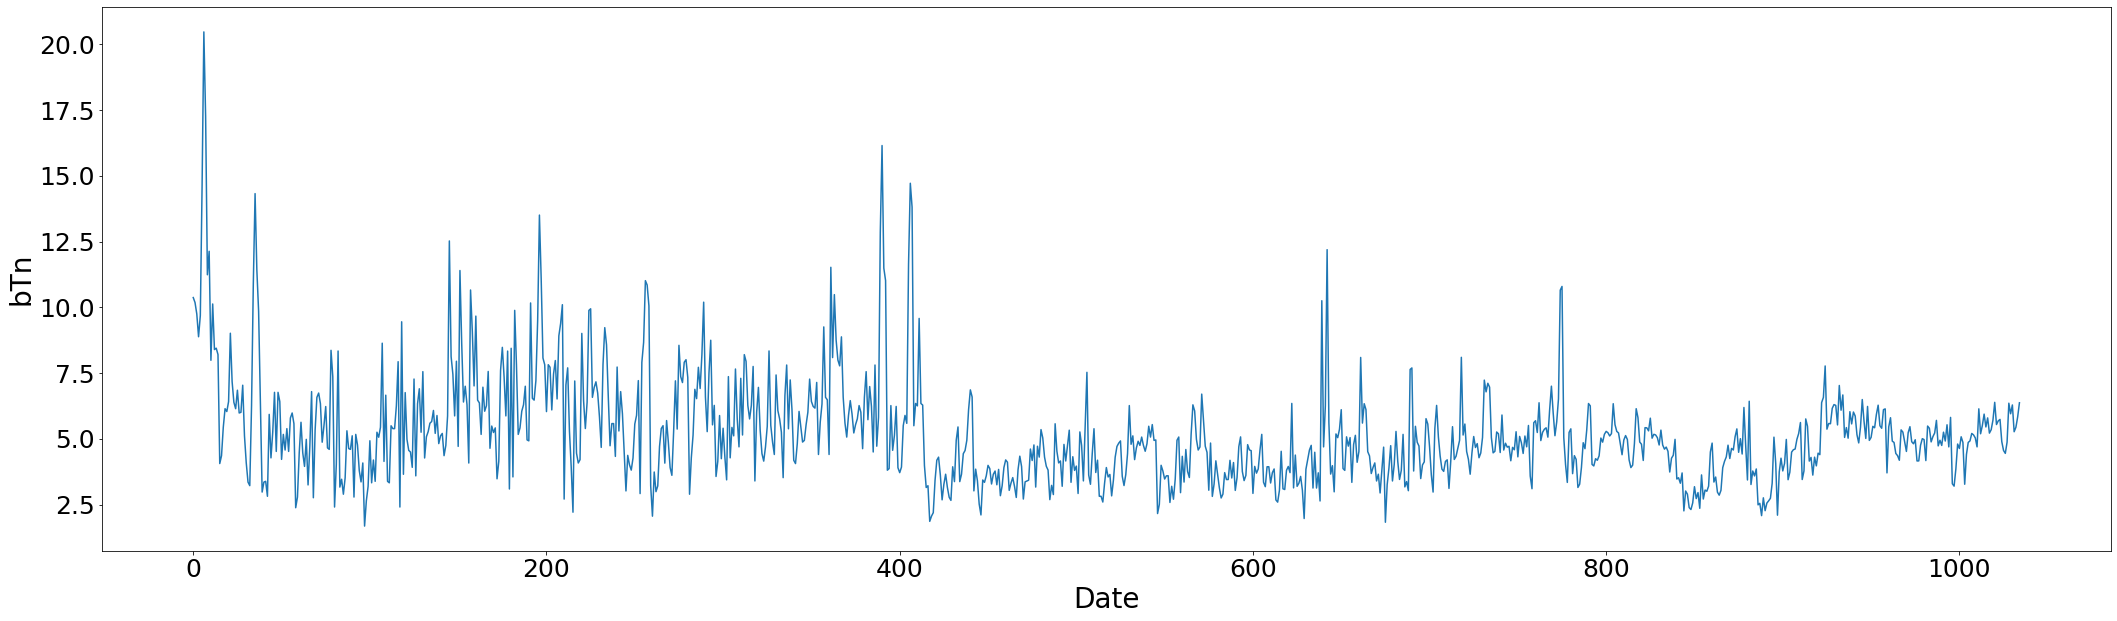

In [46]:
plt.figure(figsize=(36,10))
plt.plot(df.bTn)
plt.xlabel('Date')
plt.ylabel('bTn')
plt.show()

In [47]:
dataset = df.bTn.values
#dataset = dataset.astype('float32')
dataset = dataset.reshape(-1,1)

In [48]:
# LSTM is sensitive to scale, thus a scaler is necessary.
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [49]:
#Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

776 259


In [50]:
def creat_dataset(data, lagTerm=1):
    # To create the dataset for later use.
    # lagTerm: How many previous timestemp's data will be used.
    dataX, dataY = [],[]
    for i in range(len(data) - lagTerm -1):
        cache = data[i:(i+lagTerm),0]
        dataX.append(cache)
        dataY.append(data[i+lagTerm,0])
    return np.array(dataX), np.array(dataY)

In [51]:
look_back = 6
trainX,trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [52]:
#reshape input into to be [samples, time_steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [53]:
# Set a valida set to avoid overfitting
validX = trainX[776:]
validY = trainY[776:]
trainX = trainX[:775]
trainY = trainY[:775]

## Model

In [54]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(1024, input_shape=(1,look_back),dropout=0.1, recurrent_dropout = 0.1)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

In [55]:
# Early stop callback function.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

In [56]:
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb])

Epoch 1/1000
25/25 - 2s - loss: 0.8416 - 2s/epoch - 94ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7447 - 271ms/epoch - 11ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.6909 - 260ms/epoch - 10ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7021 - 239ms/epoch - 10ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6967 - 233ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6752 - 242ms/epoch - 10ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6821 - 236ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6499 - 256ms/epoch - 10ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6949 - 239ms/epoch - 10ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7201 - 230ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6680 - 246ms/epoch - 10ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6802 - 234ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6738 - 229ms/epoch - 9ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6920 - 230ms/epoch - 9ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6830 - 249ms/epoch - 10ms/step
Epoch 16/1000
25/25 - 0s - l

In [57]:
eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

100%|██████████| 100/100 [00:05<00:00, 18.45it/s]


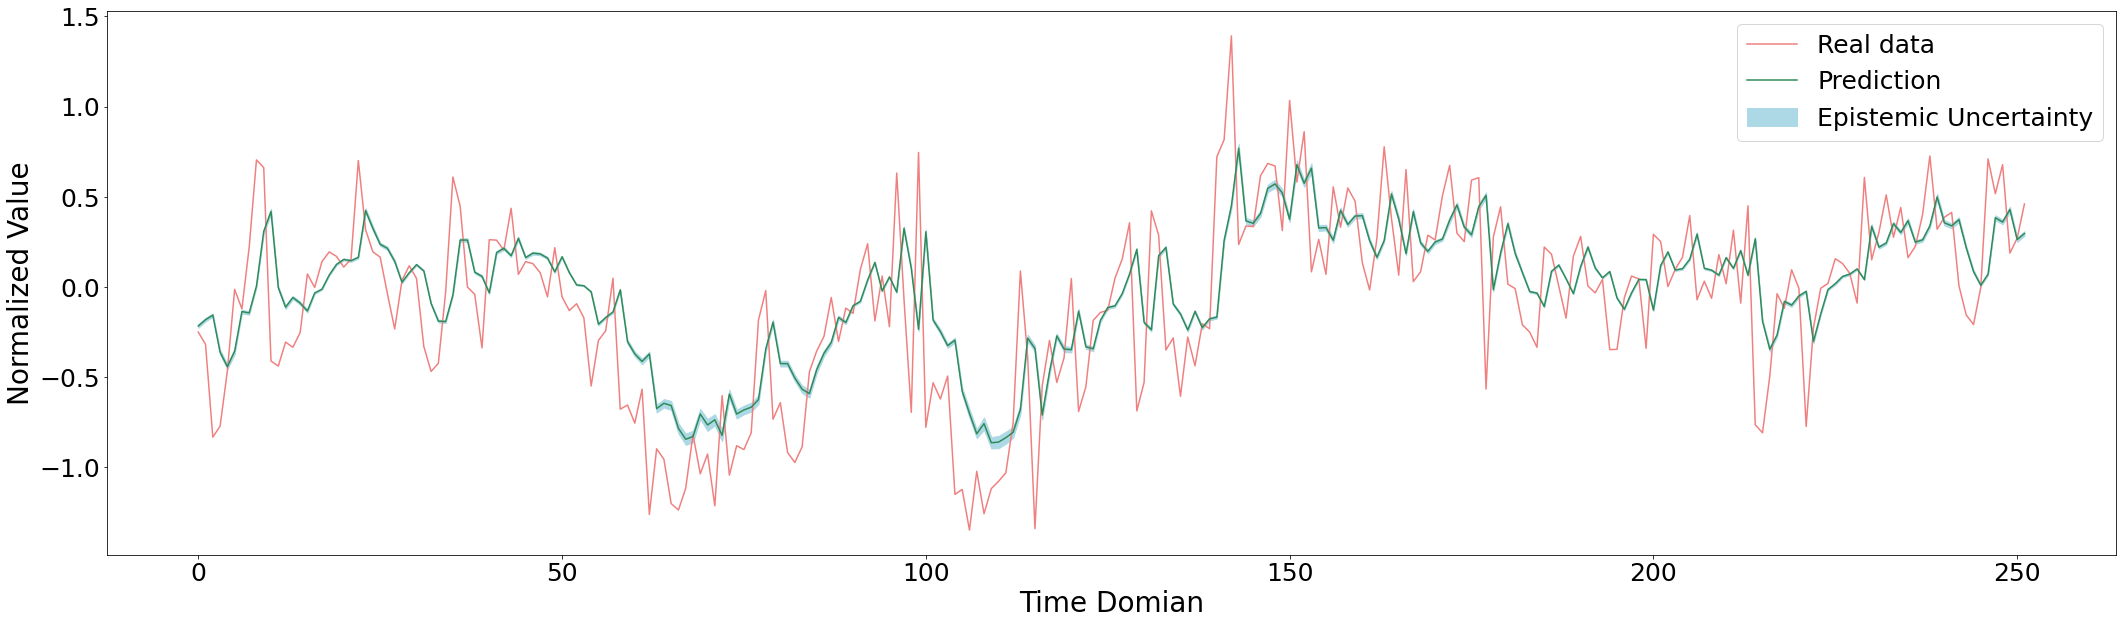

In [58]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*v**0.5, m + 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

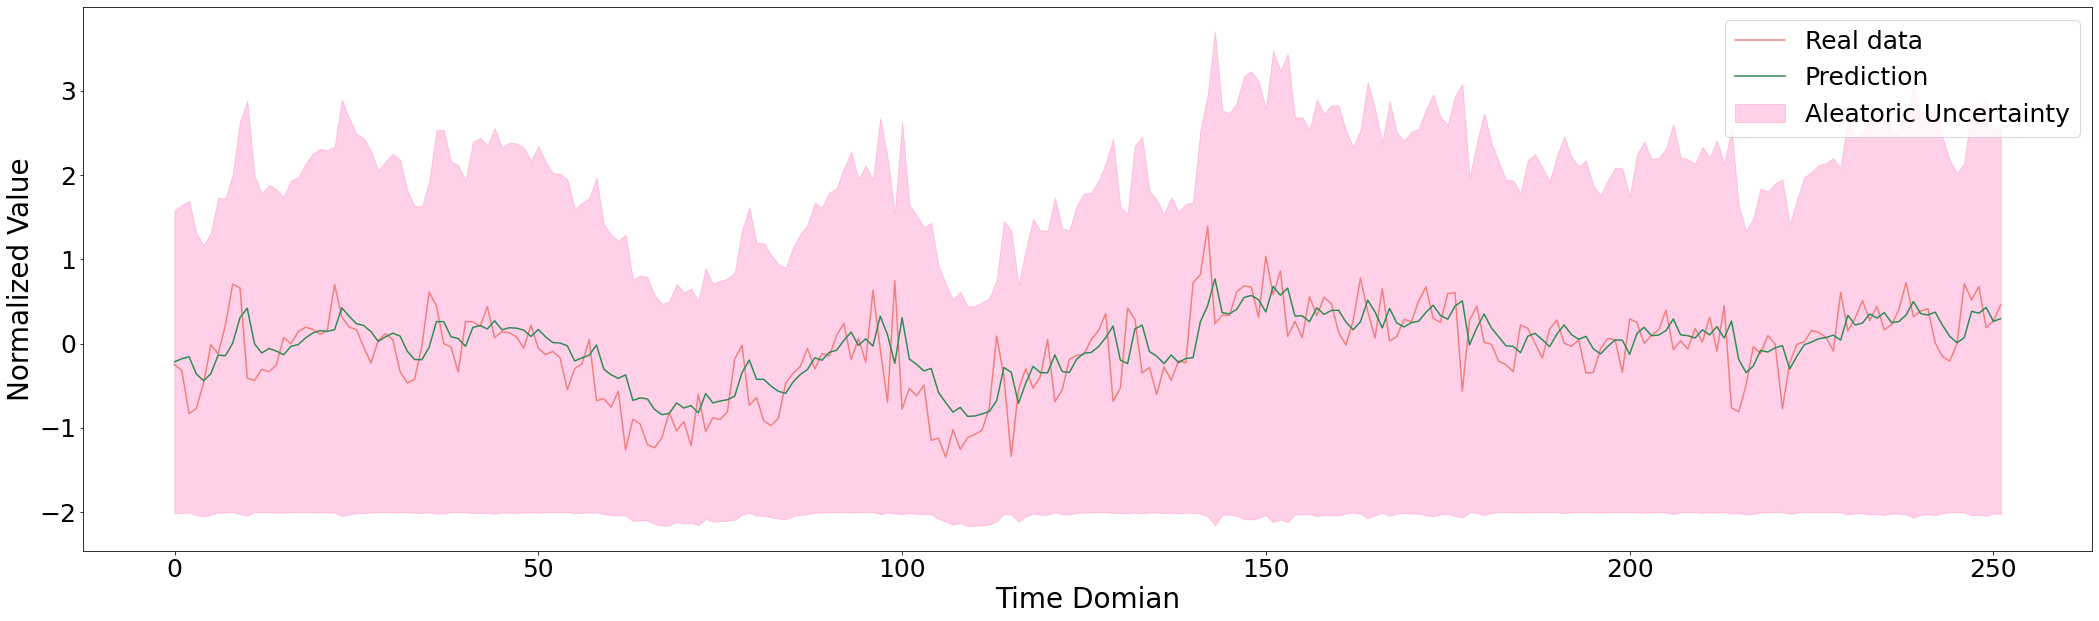

In [59]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, m - 2*a_u**0.5, m + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

In [60]:
# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Test RMSE: 0.73 
Test MSE: 0.54 
Test r_squared: 0.52.


hyper tuning

In [61]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)




layer_range = [16,32,64,128,256,512]
dropout_range = [0.1,0.2,0.3]
recurrent_dropout_range = [0.1,0.2,0.3]

best_mse = 100
best_rmse = 0
best_r2 = 0 

for lay in layer_range:
    for drop in dropout_range:
        for recur in recurrent_dropout_range:
            theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],lay,drop,recur)

            eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
            ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
            eps = np.array(eps)
            ale = np.array(ale)
            m = np.mean(eps, axis=0).flatten() # predictive mean
            v = np.var(eps, axis=0).flatten() # epistemic uncertainty
            a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
            a_u = a_u.squeeze()
            v = v.squeeze()
            # Upper and lower bounds
            al_up = m + 2*a_u**0.5
            al_down = m - 2*a_u**0.5
            ep_up = m + 2*v**0.5
            ep_down = m - 2*v**0.5

            #reshape to (-1,1)
            trainY = trainY.reshape(-1,1)
            testY = testY.reshape(-1,1)
            m = m.reshape(-1,1)
            al_up = al_up.reshape(-1,1)
            al_down = al_down.reshape(-1,1)
            ep_up = ep_up.reshape(-1,1)
            ep_down = ep_down.reshape(-1,1)

            # invert predictions
            testPredict = scaler.inverse_transform(m)
            truth = scaler.inverse_transform(testY)
            epUp = scaler.inverse_transform(ep_up)
            epDown = scaler.inverse_transform(ep_down) 
            alUp = scaler.inverse_transform(al_up)
            alDown = scaler.inverse_transform(al_down)


            # RMSE
            testRScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
            #print('Test RMSE: %.2f ' % (testScore))

            # MSE
            testScore = mean_squared_error(truth[:,0], testPredict[:,0])
            #print('Test MSE: %.2f ' % (testScore))

            #r2
            r2 = r2_score(truth, testPredict)
            #print('Test r_squared: %.2f.' % (r2))

            if testScore <= best_mse:
                best_layer = lay
                best_dropout = drop
                best_recurrent_dropout = recur
                best_mse = testScore
                best_rmse = testRScore
                best_r2 = r2

            print("Layer = "+str(lay)+ " Dropout = "+str(drop)+" Recurrent_dropout = "+str(recur)+ 'Test RMSE: %.2f ' % (testRScore)+'Test MSE: %.2f ' % (testScore)+'Test r_squared: %.2f.' % (r2))

print("Best Layer = "+str(best_layer)+ "\nBest Dropout = "+str(best_dropout)+"\nRecurrent_dropout = "+str(best_recurrent_dropout)+ '\nTest RMSE: %.2f ' % (best_rmse)+'\nTest MSE: %.2f ' % (best_mse)+'\nTest r_squared: %.2f.' % (best_r2))

Epoch 1/1000
25/25 - 2s - loss: 0.9649 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8930 - 204ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8469 - 194ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8206 - 191ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7786 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7715 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7646 - 199ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7453 - 196ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7346 - 184ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7398 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7414 - 204ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7301 - 207ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7433 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7219 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6973 - 182ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 17.22it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.1822 - 2s/epoch - 90ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0906 - 193ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 1.0186 - 193ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.9740 - 204ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8980 - 187ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8753 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8359 - 194ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8327 - 203ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.8066 - 205ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7847 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7867 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7596 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7565 - 183ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7309 - 201ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7425 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.64it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.0256 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9465 - 196ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8851 - 203ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8520 - 208ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8091 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7986 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7733 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7756 - 199ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7620 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7622 - 191ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7530 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7333 - 188ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7231 - 210ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7115 - 209ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7170 - 190ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.67it/s]

Layer = 16 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.0423 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9727 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9152 - 201ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8869 - 189ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8402 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8332 - 185ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7970 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8038 - 207ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7831 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7610 - 193ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7620 - 187ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7741 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7405 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7586 - 186ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7364 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:06<00:00, 16.53it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.78 Test MSE: 0.61 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.1605 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0942 - 198ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 1.0570 - 188ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 1.0026 - 191ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.9694 - 201ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.9088 - 182ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8835 - 202ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8643 - 205ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.8250 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.8204 - 192ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7931 - 191ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7808 - 199ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7834 - 188ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7537 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7528 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.86it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 2s - loss: 1.0263 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9460 - 197ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8901 - 200ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8690 - 197ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8127 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8292 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8062 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7882 - 186ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7677 - 192ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7819 - 190ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7583 - 187ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7741 - 185ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7462 - 190ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7429 - 199ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7362 - 185ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.68it/s]

Layer = 16 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.0560 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0113 - 204ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9532 - 204ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.9232 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8874 - 189ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8726 - 188ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8480 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8206 - 196ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.8063 - 213ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7859 - 208ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7887 - 197ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.8014 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7842 - 185ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.8044 - 202ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7538 - 193ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.60it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.82 Test MSE: 0.68 Test r_squared: 0.39.


Epoch 1/1000
25/25 - 2s - loss: 1.1667 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0981 - 185ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 1.0640 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.9917 - 189ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.9541 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.9125 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8840 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8664 - 205ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.8317 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.8247 - 185ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.8300 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.8100 - 200ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.8262 - 190ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7943 - 198ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7812 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.54it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.80 Test MSE: 0.63 Test r_squared: 0.43.


Epoch 1/1000
25/25 - 2s - loss: 1.1444 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0905 - 186ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 1.0290 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.9971 - 205ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.9513 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.9399 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.9077 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8965 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.8690 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.8444 - 188ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.8526 - 188ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.8354 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.8276 - 188ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.8386 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.8014 - 192ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.8

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]

Layer = 16 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.0527 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9442 - 185ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8679 - 192ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8276 - 187ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7886 - 189ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7660 - 197ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7660 - 191ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7430 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7221 - 204ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7289 - 188ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7063 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7364 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7046 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6988 - 193ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6882 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.73it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 2s - loss: 1.0722 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9608 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8682 - 195ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8117 - 191ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8014 - 189ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7744 - 182ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7420 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7334 - 193ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7224 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7087 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6966 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7037 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7075 - 199ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6910 - 187ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6779 - 201ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.32it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 2s - loss: 1.0972 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9792 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9095 - 188ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8549 - 196ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8174 - 186ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7785 - 202ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7733 - 192ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7506 - 186ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7338 - 198ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7207 - 199ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7202 - 212ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7123 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7081 - 191ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7112 - 189ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7171 - 200ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.80it/s]

Layer = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.0447 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9024 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8505 - 198ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7697 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7600 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7470 - 201ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7223 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7739 - 191ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7083 - 190ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7591 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7165 - 185ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7500 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7454 - 198ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7375 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7294 - 198ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.39it/s]

Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.78 Test MSE: 0.60 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 2s - loss: 1.0738 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9628 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8852 - 186ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8294 - 204ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7927 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7614 - 188ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7811 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7648 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7409 - 208ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7336 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7146 - 208ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7229 - 188ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7493 - 196ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7284 - 207ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7248 - 192ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.54it/s]

Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.1110 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0134 - 195ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9404 - 202ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8550 - 212ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8456 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8056 - 198ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7752 - 210ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7532 - 204ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7609 - 183ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7514 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7363 - 192ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7297 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7488 - 196ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7467 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7408 - 193ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 17.53it/s]

Layer = 32 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 2s - loss: 1.1756 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0663 - 194ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9719 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.9121 - 219ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8543 - 203ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8332 - 191ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8264 - 187ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7933 - 191ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7827 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7939 - 214ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7849 - 188ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7814 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7926 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7917 - 202ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7964 - 186ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.37it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 1.0531 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9215 - 193ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8722 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8230 - 193ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7837 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7933 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7934 - 202ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7479 - 193ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7569 - 186ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7320 - 185ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7156 - 185ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7091 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7287 - 199ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7356 - 193ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7248 - 187ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.09it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.78 Test MSE: 0.61 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 2s - loss: 1.1199 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 1.0093 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.9378 - 189ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8896 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8519 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.8190 - 199ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.8047 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7965 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7765 - 191ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7456 - 192ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7531 - 189ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7529 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7713 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7459 - 199ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7454 - 206ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.00it/s]

Layer = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.79 Test MSE: 0.63 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 0.9811 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8529 - 183ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7728 - 194ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7485 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7256 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7099 - 185ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6874 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6796 - 185ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6651 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6779 - 196ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6699 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6545 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6885 - 185ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6628 - 195ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6660 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.73it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 1.0286 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9004 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7956 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7617 - 189ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7277 - 187ms/epoch - 7ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7311 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7080 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7003 - 200ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6998 - 184ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6926 - 191ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6937 - 189ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7087 - 188ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6594 - 200ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6946 - 188ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6788 - 186ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.65it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 1.0421 - 2s/epoch - 99ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8883 - 207ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8310 - 191ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7796 - 189ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7529 - 193ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7238 - 200ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7086 - 204ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7003 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7343 - 189ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6986 - 194ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6666 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6746 - 218ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7058 - 197ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7005 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6944 - 186ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.69it/s]

Layer = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 0.9906 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8705 - 207ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7893 - 186ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7589 - 190ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7600 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7586 - 187ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7234 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7379 - 201ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6956 - 191ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7532 - 186ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6975 - 185ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6997 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6880 - 184ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7222 - 191ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7055 - 195ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.74it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.9928 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8796 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8114 - 182ms/epoch - 7ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7780 - 203ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7443 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7304 - 194ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7366 - 183ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7118 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7104 - 192ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7437 - 192ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7199 - 186ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7282 - 183ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7016 - 190ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6925 - 194ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6974 - 192ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.62it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.0588 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9323 - 188ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8613 - 189ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8299 - 200ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.8200 - 208ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7683 - 186ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7714 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7597 - 193ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7530 - 186ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7290 - 203ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7362 - 194ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7066 - 188ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7236 - 195ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7175 - 186ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7308 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]

Layer = 64 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.9809 - 2s/epoch - 97ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8532 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7785 - 205ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7770 - 187ms/epoch - 7ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7498 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7593 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7776 - 186ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7834 - 190ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7644 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7726 - 182ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7240 - 199ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7774 - 196ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7291 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7298 - 195ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7667 - 183ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.34it/s]

Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.0902 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9393 - 184ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8504 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8142 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7799 - 196ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7557 - 192ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7636 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7463 - 185ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7306 - 191ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7715 - 190ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7094 - 191ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6865 - 203ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7676 - 189ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7171 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7456 - 197ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.54it/s]


Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.78 Test MSE: 0.61 Test r_squared: 0.45.
Epoch 1/1000
25/25 - 2s - loss: 1.0221 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8852 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8255 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8102 - 192ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7575 - 200ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7468 - 200ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7736 - 193ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7494 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7281 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7170 - 199ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7580 - 184ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7612 - 193ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7242 - 193ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7569 - 193ms/epoch - 8ms/step


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]

Layer = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.61 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 2s - loss: 0.9590 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8075 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7562 - 190ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7234 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6915 - 192ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7153 - 208ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7096 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6704 - 185ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6804 - 187ms/epoch - 7ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6939 - 182ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6582 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7024 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6512 - 188ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6690 - 197ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6892 - 187ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 16.75it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9915 - 2s/epoch - 93ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8145 - 212ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7676 - 208ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7429 - 198ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7250 - 209ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6698 - 218ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6698 - 188ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7007 - 202ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7118 - 190ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6772 - 191ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6601 - 194ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6586 - 201ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6552 - 208ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6772 - 197ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6910 - 189ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.39it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 0.9336 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7903 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7585 - 194ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7347 - 193ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7065 - 199ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6980 - 185ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6802 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6774 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7193 - 199ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6743 - 209ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6919 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6660 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6733 - 184ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6666 - 187ms/epoch - 7ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6706 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 17.61it/s]

Layer = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 1.0113 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8509 - 201ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7828 - 195ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7588 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7172 - 192ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7405 - 189ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6793 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7025 - 183ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6765 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7066 - 187ms/epoch - 7ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7194 - 186ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6566 - 204ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7036 - 182ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7310 - 193ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6834 - 190ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 17.96it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9632 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8288 - 190ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7695 - 191ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7530 - 203ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7044 - 196ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7354 - 187ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7100 - 191ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6941 - 206ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6992 - 209ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6702 - 189ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6930 - 192ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6842 - 183ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6636 - 195ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6911 - 196ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7558 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.53it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 1.0406 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8423 - 187ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7796 - 196ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7726 - 213ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7444 - 191ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7505 - 187ms/epoch - 7ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7517 - 192ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7174 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6949 - 212ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6489 - 213ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7349 - 200ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6763 - 212ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6582 - 206ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6919 - 202ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6871 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.03it/s]

Layer = 128 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9600 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8086 - 189ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7910 - 203ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.8073 - 195ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7697 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7533 - 188ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7486 - 190ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7354 - 203ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7204 - 199ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7473 - 198ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7555 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7113 - 190ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7440 - 205ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7535 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7087 - 193ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 3s - loss: 0.9663 - 3s/epoch - 100ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8346 - 184ms/epoch - 7ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8071 - 197ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7601 - 200ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7573 - 189ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7443 - 201ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7400 - 199ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7544 - 197ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7136 - 211ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7217 - 189ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7356 - 197ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7458 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7140 - 193ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7202 - 208ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7815 - 182ms/epoch - 7ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 1.0074 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8380 - 201ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7746 - 195ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7835 - 197ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7257 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7514 - 205ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7489 - 181ms/epoch - 7ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7519 - 188ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7181 - 195ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7310 - 198ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7762 - 224ms/epoch - 9ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7642 - 186ms/epoch - 7ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7557 - 184ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7283 - 205ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7420 - 193ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.49it/s]

Layer = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.9799 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7766 - 206ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7506 - 194ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7411 - 197ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7297 - 211ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7178 - 199ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6776 - 196ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7007 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6737 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6950 - 209ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6735 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6619 - 200ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6879 - 193ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6580 - 197ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6813 - 208ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.15it/s]

Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 0.9189 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7813 - 199ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7236 - 200ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6900 - 207ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6928 - 206ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6922 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6675 - 194ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6874 - 197ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6830 - 198ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6790 - 202ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6640 - 192ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6617 - 199ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6552 - 203ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7022 - 203ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6905 - 198ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.60it/s]

Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 2s - loss: 0.9285 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8023 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7522 - 201ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7292 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6875 - 216ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6603 - 208ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6958 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7151 - 201ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6793 - 207ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7473 - 217ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6617 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6677 - 206ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6682 - 203ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6730 - 202ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6487 - 195ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.28it/s]

Layer = 256 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 2s - loss: 0.9452 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7849 - 206ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7465 - 207ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7504 - 193ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7067 - 201ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6803 - 222ms/epoch - 9ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7165 - 199ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7177 - 187ms/epoch - 7ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7046 - 200ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7359 - 196ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7114 - 205ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7154 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7016 - 199ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7292 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7104 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.27it/s]

Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 2s - loss: 0.9504 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7909 - 197ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7445 - 206ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7618 - 196ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7104 - 194ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7038 - 211ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7703 - 193ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7635 - 202ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7146 - 194ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7266 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7333 - 205ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6784 - 195ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7095 - 201ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6824 - 196ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6957 - 192ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.10it/s]

Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 0.9664 - 2s/epoch - 89ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7752 - 200ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7818 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7309 - 194ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7390 - 204ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7202 - 202ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7183 - 223ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6719 - 204ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6718 - 203ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6790 - 211ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7331 - 202ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7222 - 206ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6825 - 194ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6936 - 198ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6916 - 195ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.33it/s]

Layer = 256 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9352 - 2s/epoch - 100ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7913 - 210ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7701 - 205ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7560 - 215ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7474 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7276 - 196ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7421 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7588 - 194ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7259 - 204ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7060 - 195ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7710 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7215 - 193ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7665 - 187ms/epoch - 7ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7470 - 208ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7151 - 189ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.36it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 2s - loss: 0.9798 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8292 - 204ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7487 - 210ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7342 - 205ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7637 - 192ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7190 - 200ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7594 - 192ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7475 - 199ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7198 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7223 - 188ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7260 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6842 - 199ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7522 - 211ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7448 - 195ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7029 - 203ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.48it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 2s - loss: 0.9598 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8191 - 193ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8066 - 208ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7497 - 199ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7230 - 192ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7428 - 193ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7532 - 200ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7393 - 207ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7069 - 206ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7514 - 203ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7532 - 199ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7251 - 189ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7208 - 200ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6834 - 200ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7313 - 191ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 17.98it/s]

Layer = 256 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 2s - loss: 0.8942 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7474 - 210ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7050 - 201ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7130 - 196ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6987 - 212ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6723 - 196ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6915 - 207ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6898 - 196ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6691 - 198ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6826 - 213ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6802 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6709 - 200ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6343 - 203ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7258 - 200ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6757 - 212ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.46it/s]

Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 2s - loss: 0.9513 - 2s/epoch - 97ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7518 - 205ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7339 - 209ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6948 - 207ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7021 - 198ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6776 - 201ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6750 - 198ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7191 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6669 - 217ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6549 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6566 - 187ms/epoch - 7ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6808 - 197ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6648 - 202ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6854 - 209ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6493 - 200ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.36it/s]

Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.2Test RMSE: 0.74 Test MSE: 0.54 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 2s - loss: 0.8659 - 2s/epoch - 88ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7607 - 206ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.6970 - 216ms/epoch - 9ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7017 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7053 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6682 - 211ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6693 - 206ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6863 - 198ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6697 - 196ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6975 - 207ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6668 - 211ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6756 - 199ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6550 - 206ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6724 - 200ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6909 - 199ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.15it/s]

Layer = 512 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.73 Test MSE: 0.54 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 2s - loss: 0.9187 - 2s/epoch - 85ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7630 - 211ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7653 - 196ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7107 - 204ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7512 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7055 - 199ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6672 - 197ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6979 - 189ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6829 - 193ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7164 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7757 - 198ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7305 - 196ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7387 - 197ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6974 - 192ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6998 - 201ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.32it/s]

Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9581 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7856 - 213ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7420 - 202ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7265 - 203ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7120 - 197ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6887 - 197ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7481 - 211ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7479 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7314 - 195ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7002 - 204ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6875 - 199ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6975 - 218ms/epoch - 9ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7338 - 200ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7094 - 190ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7387 - 196ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.42it/s]

Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.9059 - 2s/epoch - 99ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7513 - 203ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7177 - 200ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7211 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6952 - 210ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7209 - 212ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6726 - 203ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7045 - 192ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7307 - 195ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6869 - 197ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7290 - 207ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6843 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6735 - 200ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6743 - 200ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7259 - 202ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.15it/s]

Layer = 512 Dropout = 0.2 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9185 - 2s/epoch - 90ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7250 - 196ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7383 - 197ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7437 - 201ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7444 - 195ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7191 - 211ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6898 - 207ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7394 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7746 - 195ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7209 - 198ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7355 - 195ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7211 - 193ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7462 - 198ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7100 - 198ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7783 - 194ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.08it/s]

Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 2s - loss: 0.9152 - 2s/epoch - 87ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8276 - 208ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7738 - 199ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7985 - 215ms/epoch - 9ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7554 - 205ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7672 - 202ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7665 - 200ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7631 - 195ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7147 - 213ms/epoch - 9ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7351 - 213ms/epoch - 9ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7626 - 196ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7053 - 198ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7301 - 192ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7010 - 222ms/epoch - 9ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7395 - 209ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.6

100%|██████████| 100/100 [00:05<00:00, 18.24it/s]

Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.2Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 2s - loss: 0.9166 - 2s/epoch - 86ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8099 - 194ms/epoch - 8ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8051 - 215ms/epoch - 9ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7735 - 208ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7517 - 202ms/epoch - 8ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7541 - 195ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7746 - 189ms/epoch - 8ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8002 - 205ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7596 - 203ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7121 - 207ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7608 - 193ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7407 - 199ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7463 - 212ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7132 - 194ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7135 - 212ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.7

100%|██████████| 100/100 [00:05<00:00, 18.35it/s]

Layer = 512 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.
Best Layer = 512
Best Dropout = 0.1
Recurrent_dropout = 0.3
Test RMSE: 0.73 
Test MSE: 0.54 
Test r_squared: 0.51.


In [62]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],best_layer,best_dropout,best_recurrent_dropout)

eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

print()
# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Epoch 1/1000
25/25 - 3s - loss: 0.8901 - 3s/epoch - 100ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7543 - 227ms/epoch - 9ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7222 - 212ms/epoch - 8ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7136 - 202ms/epoch - 8ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6750 - 228ms/epoch - 9ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7164 - 204ms/epoch - 8ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6789 - 215ms/epoch - 9ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6530 - 205ms/epoch - 8ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6925 - 204ms/epoch - 8ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6655 - 206ms/epoch - 8ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7058 - 209ms/epoch - 8ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6688 - 191ms/epoch - 8ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6504 - 203ms/epoch - 8ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7137 - 200ms/epoch - 8ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6635 - 203ms/epoch - 8ms/step
Epoch 16/1000
25/25 - 0s - loss: 0.

100%|██████████| 100/100 [00:05<00:00, 18.84it/s]


Test RMSE: 0.74 
Test MSE: 0.54 
Test r_squared: 0.51.


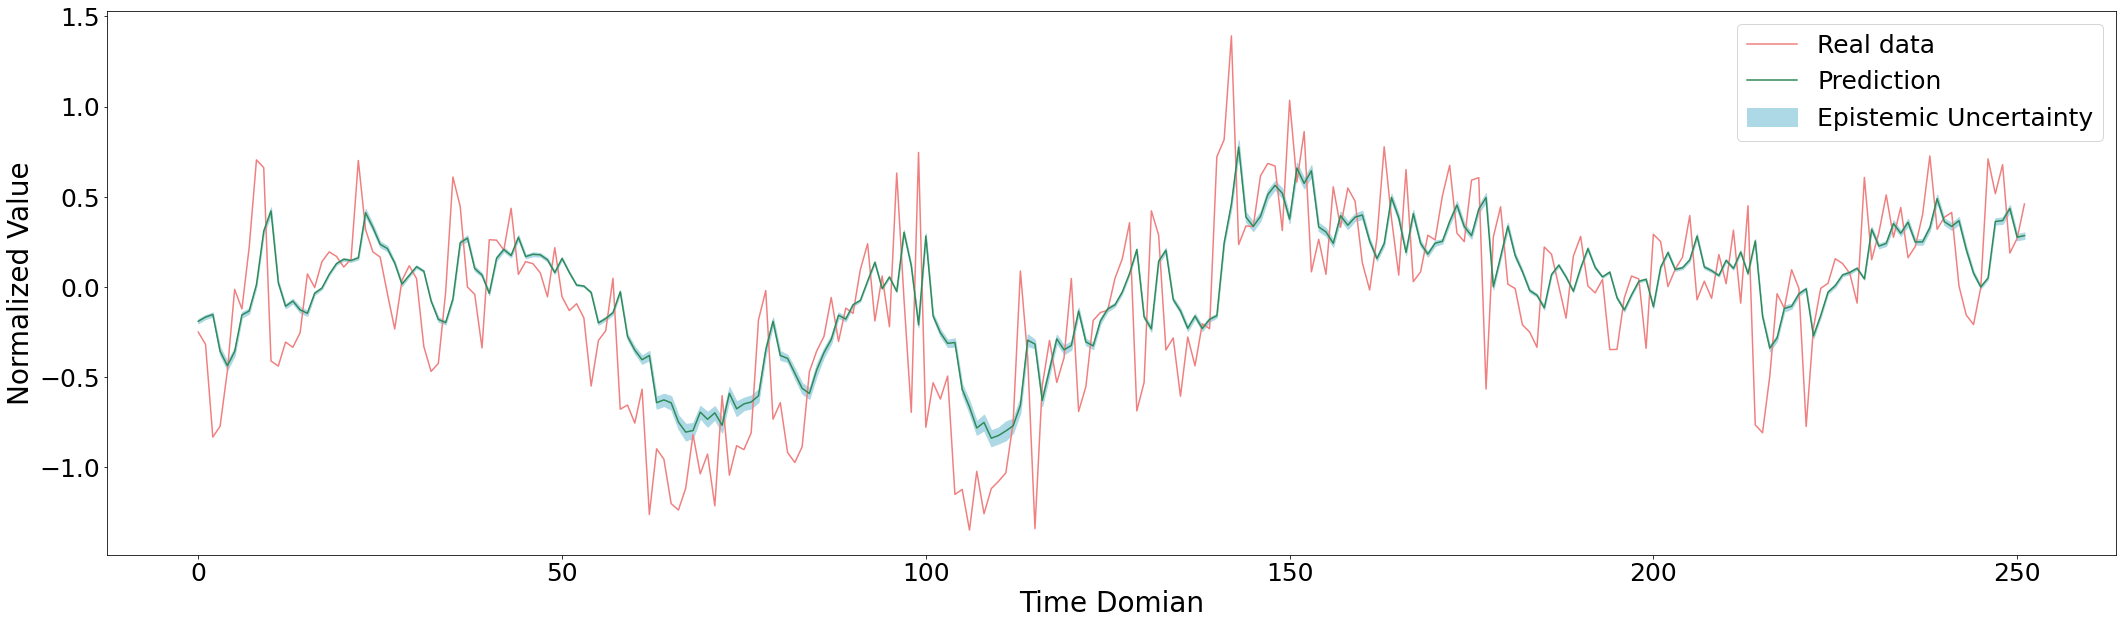

In [63]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() + 2*v**0.5, np.mean(eps, axis=0).flatten() - 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

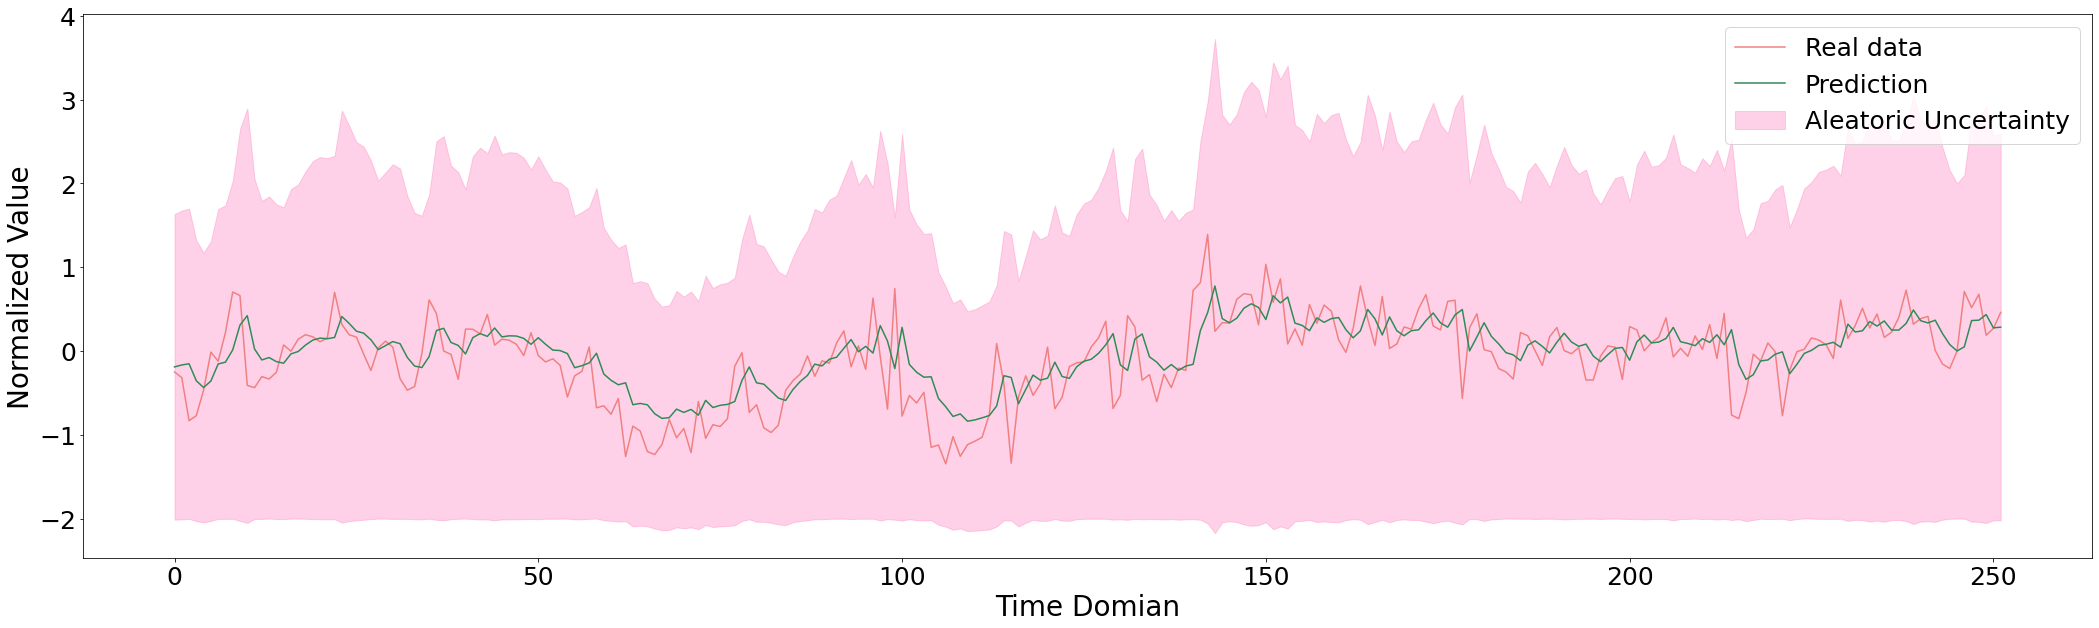

In [64]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() - 2*a_u**0.5, np.mean(eps, axis=0).flatten() + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')

hyper 2 

In [65]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay1,lay2,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay1, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur,return_sequences=True)(x)
    x = LSTM(lay2, dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)




layer1_range = [128,256,512]
layer2_range = [32,64,128]

dropout_range = [0.1,0.3]
recurrent_dropout_range = [0.1,0.3]

best_mse = 100
best_rmse = 0
best_r2 = 0 

for lay1 in layer1_range:
    for lay2 in layer2_range:
        for drop in dropout_range:
            for recur in recurrent_dropout_range:
                theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],lay1,lay2,drop,recur)

                eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
                ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
                eps = np.array(eps)
                ale = np.array(ale)
                m = np.mean(eps, axis=0).flatten() # predictive mean
                v = np.var(eps, axis=0).flatten() # epistemic uncertainty
                a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
                a_u = a_u.squeeze()
                v = v.squeeze()
                # Upper and lower bounds
                al_up = m + 2*a_u**0.5
                al_down = m - 2*a_u**0.5
                ep_up = m + 2*v**0.5
                ep_down = m - 2*v**0.5

                #reshape to (-1,1)
                trainY = trainY.reshape(-1,1)
                testY = testY.reshape(-1,1)
                m = m.reshape(-1,1)
                al_up = al_up.reshape(-1,1)
                al_down = al_down.reshape(-1,1)
                ep_up = ep_up.reshape(-1,1)
                ep_down = ep_down.reshape(-1,1)

                # invert predictions
                testPredict = scaler.inverse_transform(m)
                truth = scaler.inverse_transform(testY)
                epUp = scaler.inverse_transform(ep_up)
                epDown = scaler.inverse_transform(ep_down) 
                alUp = scaler.inverse_transform(al_up)
                alDown = scaler.inverse_transform(al_down)


                # RMSE
                testRScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
                #print('Test RMSE: %.2f ' % (testScore))

                # MSE
                testScore = mean_squared_error(truth[:,0], testPredict[:,0])
                #print('Test MSE: %.2f ' % (testScore))

                #r2
                r2 = r2_score(truth, testPredict)
                #print('Test r_squared: %.2f.' % (r2))

                if testScore <= best_mse:
                    best_layer1 = lay1
                    best_layer2 = lay2
                    best_dropout = drop
                    best_recurrent_dropout = recur
                    best_mse = testScore
                    best_rmse = testRScore
                    best_r2 = r2

                print("Layer1 = "+str(lay1)+"Layer2 = "+str(lay2)+ " Dropout = "+str(drop)+" Recurrent_dropout = "+str(recur)+ 'Test RMSE: %.2f ' % (testRScore)+'Test MSE: %.2f ' % (testScore)+'Test r_squared: %.2f.' % (r2))

print("Best Layer1 = "+str(best_layer1)+"Best Layer2 = "+str(best_layer2)+ "\nBest Dropout = "+str(best_dropout)+"\nRecurrent_dropout = "+str(best_recurrent_dropout)+ '\nTest RMSE: %.2f ' % (best_rmse)+'\nTest MSE: %.2f ' % (best_mse)+'\nTest r_squared: %.2f.' % (best_r2))

Epoch 1/1000
25/25 - 4s - loss: 1.0594 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8627 - 349ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7691 - 362ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7413 - 343ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7295 - 339ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6902 - 339ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6965 - 335ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7113 - 336ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6961 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6784 - 330ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7083 - 339ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6783 - 357ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7119 - 342ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6719 - 341ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6624 - 339ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.50it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 4s - loss: 1.0526 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8959 - 349ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7907 - 353ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7682 - 331ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7131 - 345ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7013 - 329ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6804 - 336ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6790 - 351ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7172 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6994 - 328ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6926 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6787 - 336ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6782 - 337ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6993 - 367ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7088 - 353ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.62it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 5s - loss: 1.0472 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9064 - 344ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7992 - 353ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7701 - 378ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7677 - 356ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7431 - 329ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7513 - 347ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7463 - 352ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7477 - 322ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.8091 - 347ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7793 - 340ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7514 - 355ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7604 - 338ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7758 - 361ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7224 - 334ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.42it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 4s - loss: 1.0533 - 4s/epoch - 165ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.9034 - 329ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8120 - 342ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7817 - 350ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7490 - 330ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7252 - 346ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7538 - 333ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7471 - 336ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7832 - 355ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7782 - 335ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7443 - 343ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7535 - 351ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7431 - 337ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7659 - 349ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7673 - 345ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.71it/s]

Layer1 = 128Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.61 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 4s - loss: 1.0374 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8153 - 369ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7346 - 350ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7154 - 340ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6825 - 344ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6805 - 344ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7017 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6814 - 343ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6987 - 339ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6926 - 347ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6809 - 341ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6515 - 347ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6651 - 344ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6485 - 333ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6559 - 361ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.57it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 5s - loss: 1.0344 - 5s/epoch - 185ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7802 - 350ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7916 - 340ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7356 - 337ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7034 - 347ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6943 - 354ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6975 - 335ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6885 - 339ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7020 - 340ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6903 - 349ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6674 - 329ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6904 - 354ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6744 - 344ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7105 - 326ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6765 - 354ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.75it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 5s - loss: 1.0562 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8783 - 336ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8153 - 346ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7763 - 339ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7597 - 338ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7362 - 353ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7803 - 346ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7595 - 347ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7516 - 344ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7120 - 344ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7249 - 336ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7239 - 342ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7143 - 337ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7050 - 343ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7421 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.60it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 4s - loss: 1.0428 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8554 - 350ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7629 - 366ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7507 - 357ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7520 - 344ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7822 - 353ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7316 - 356ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7467 - 323ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7091 - 345ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7511 - 354ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7512 - 337ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7432 - 336ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7680 - 343ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7694 - 332ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7217 - 334ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.58it/s]

Layer1 = 128Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 4s - loss: 1.0166 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7489 - 344ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7136 - 351ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6943 - 345ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6873 - 342ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6965 - 328ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6851 - 347ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7016 - 348ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7162 - 338ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6964 - 346ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6678 - 329ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6708 - 343ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6971 - 340ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6889 - 340ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6351 - 360ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.75it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.74 Test MSE: 0.54 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 5s - loss: 1.0051 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7695 - 346ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7056 - 352ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6727 - 351ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6824 - 346ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7185 - 340ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6726 - 354ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6751 - 325ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7139 - 348ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6936 - 337ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6600 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6696 - 355ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6715 - 340ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6902 - 328ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6690 - 351ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.76it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 5s - loss: 1.0193 - 5s/epoch - 181ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8398 - 358ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7605 - 351ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7885 - 363ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7495 - 349ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7596 - 333ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7692 - 338ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7157 - 342ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7492 - 338ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7332 - 353ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7171 - 368ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7262 - 334ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7316 - 328ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7072 - 339ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7468 - 330ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.63it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 4s - loss: 1.0312 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8084 - 353ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7892 - 342ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7461 - 339ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7320 - 349ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7605 - 329ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7229 - 345ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7282 - 346ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7303 - 347ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7088 - 348ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7433 - 335ms/epoch - 13ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7697 - 337ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7223 - 362ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7464 - 347ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7332 - 358ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.77it/s]

Layer1 = 128Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 5s - loss: 0.9818 - 5s/epoch - 190ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7796 - 377ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7360 - 356ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7072 - 359ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7237 - 328ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6813 - 353ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6828 - 367ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6744 - 341ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7112 - 366ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6738 - 348ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7120 - 340ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6743 - 347ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6686 - 353ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6767 - 337ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6753 - 340ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.68it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 5s - loss: 1.0308 - 5s/epoch - 190ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8029 - 351ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7585 - 336ms/epoch - 13ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6995 - 354ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6808 - 360ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6947 - 360ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6915 - 343ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6842 - 334ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6894 - 354ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7205 - 366ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7146 - 379ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6649 - 368ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6735 - 338ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6502 - 349ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6492 - 368ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.54it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 4s - loss: 1.0134 - 4s/epoch - 167ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8253 - 332ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7642 - 372ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7304 - 347ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7446 - 335ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7449 - 357ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7117 - 366ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7910 - 340ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7906 - 357ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7165 - 370ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7227 - 341ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7533 - 355ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7709 - 359ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7543 - 361ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7379 - 348ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.46it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.


Epoch 1/1000
25/25 - 5s - loss: 1.0203 - 5s/epoch - 191ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8225 - 351ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7766 - 352ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7289 - 330ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7806 - 355ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7518 - 328ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7551 - 322ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7530 - 341ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7475 - 362ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7247 - 371ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7624 - 365ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7566 - 336ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7606 - 342ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7121 - 347ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7781 - 334ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.69it/s]

Layer1 = 256Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 5s - loss: 0.9959 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7738 - 355ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7343 - 344ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6944 - 366ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6822 - 346ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6957 - 339ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6870 - 348ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6988 - 343ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7285 - 327ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7434 - 334ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6767 - 354ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7002 - 338ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6762 - 349ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6617 - 377ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6864 - 340ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.41it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 4s - loss: 0.9777 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7759 - 352ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7011 - 349ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7022 - 333ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6676 - 347ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7100 - 342ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7203 - 329ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6879 - 342ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6641 - 335ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6724 - 337ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6872 - 340ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6698 - 335ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7073 - 366ms/epoch - 15ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6811 - 336ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6525 - 338ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.29it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 4s - loss: 1.0306 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8170 - 348ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7655 - 344ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7313 - 356ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7387 - 355ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7180 - 355ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7556 - 334ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.8015 - 337ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7463 - 348ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7223 - 339ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7150 - 358ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7243 - 343ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7215 - 345ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7893 - 351ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7653 - 337ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.49it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.60 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 5s - loss: 1.0182 - 5s/epoch - 184ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7957 - 357ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7855 - 350ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7734 - 361ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7893 - 346ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7624 - 336ms/epoch - 13ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7205 - 349ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7124 - 349ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7542 - 353ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7337 - 354ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6923 - 357ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7228 - 342ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7383 - 360ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7269 - 338ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7411 - 344ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]

Layer1 = 256Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 4s - loss: 0.9516 - 4s/epoch - 168ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7528 - 337ms/epoch - 13ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.6992 - 345ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7079 - 371ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6622 - 334ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6858 - 350ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6708 - 336ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6687 - 337ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6724 - 339ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6660 - 341ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6862 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6860 - 347ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6514 - 337ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6605 - 343ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6723 - 345ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.51it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 4s - loss: 0.9560 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7497 - 344ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7265 - 350ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7022 - 358ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6686 - 336ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6919 - 349ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6953 - 340ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6687 - 337ms/epoch - 13ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6800 - 347ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6831 - 347ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6648 - 349ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6842 - 354ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.8175 - 340ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6882 - 352ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6718 - 351ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.42it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 5s - loss: 0.9922 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8019 - 349ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.6949 - 338ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7607 - 341ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7650 - 343ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7102 - 364ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7303 - 347ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7116 - 352ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7452 - 341ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7735 - 341ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7254 - 345ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7569 - 329ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7218 - 351ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7492 - 340ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7681 - 338ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.01it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 5s - loss: 0.9725 - 5s/epoch - 185ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7735 - 342ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7778 - 337ms/epoch - 13ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7659 - 360ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7336 - 367ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7389 - 343ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7618 - 366ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7119 - 356ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7112 - 347ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7156 - 366ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7293 - 368ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7362 - 347ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7720 - 352ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7295 - 341ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7474 - 347ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.46it/s]

Layer1 = 256Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 4s - loss: 0.9671 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7515 - 388ms/epoch - 16ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7209 - 356ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6982 - 367ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6997 - 346ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7526 - 346ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6980 - 377ms/epoch - 15ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6845 - 373ms/epoch - 15ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6881 - 354ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6895 - 365ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6796 - 372ms/epoch - 15ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6587 - 358ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6727 - 363ms/epoch - 15ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6701 - 355ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7321 - 363ms/epoch - 15ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 15.68it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 4s - loss: 0.9560 - 4s/epoch - 174ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7768 - 372ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7164 - 347ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6952 - 350ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7062 - 357ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7088 - 357ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6771 - 355ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6800 - 353ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6719 - 350ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6919 - 346ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6896 - 354ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6931 - 331ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6741 - 356ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6789 - 343ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7225 - 343ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.04it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.76 Test MSE: 0.58 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 5s - loss: 0.9631 - 5s/epoch - 188ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8007 - 360ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7980 - 354ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7900 - 355ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7538 - 347ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7114 - 372ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7521 - 357ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7246 - 355ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7813 - 353ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7259 - 345ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7076 - 353ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7123 - 355ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7388 - 346ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6976 - 342ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7530 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.19it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.76 Test MSE: 0.57 Test r_squared: 0.48.


Epoch 1/1000
25/25 - 4s - loss: 1.0042 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8574 - 345ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.8021 - 348ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7362 - 359ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7351 - 340ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7698 - 352ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7600 - 352ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7496 - 339ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7406 - 339ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7541 - 351ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7367 - 350ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7312 - 329ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6938 - 350ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7475 - 320ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7645 - 331ms/epoch - 13ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.20it/s]

Layer1 = 512Layer2 = 32 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.78 Test MSE: 0.60 Test r_squared: 0.45.


Epoch 1/1000
25/25 - 4s - loss: 0.8892 - 4s/epoch - 171ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7793 - 365ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7266 - 360ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7396 - 366ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7072 - 362ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6909 - 344ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7249 - 337ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7005 - 348ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6930 - 343ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6792 - 342ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6664 - 359ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6765 - 341ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7037 - 352ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6558 - 357ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6671 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.40it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.50.


Epoch 1/1000
25/25 - 5s - loss: 0.9256 - 5s/epoch - 186ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7546 - 349ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.6989 - 349ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6977 - 368ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6958 - 372ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6916 - 366ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6845 - 349ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7458 - 356ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6642 - 363ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6751 - 342ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6686 - 341ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6556 - 359ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6886 - 333ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6962 - 336ms/epoch - 13ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6879 - 348ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.98it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.74 Test MSE: 0.55 Test r_squared: 0.51.


Epoch 1/1000
25/25 - 5s - loss: 0.9070 - 5s/epoch - 189ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7616 - 347ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7500 - 348ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7772 - 330ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7249 - 360ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7455 - 367ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7479 - 356ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7687 - 359ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7023 - 358ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7222 - 347ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7255 - 349ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7400 - 363ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7440 - 339ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7170 - 341ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7236 - 341ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.79it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.46.


Epoch 1/1000
25/25 - 4s - loss: 0.9557 - 4s/epoch - 170ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.8262 - 351ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7827 - 363ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7900 - 349ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7825 - 363ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7175 - 349ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7582 - 344ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7671 - 356ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7688 - 351ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7392 - 343ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7274 - 353ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7652 - 341ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7909 - 337ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7367 - 352ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7518 - 345ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 15.81it/s]

Layer1 = 512Layer2 = 64 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.80 Test MSE: 0.64 Test r_squared: 0.43.


Epoch 1/1000
25/25 - 4s - loss: 0.9216 - 4s/epoch - 172ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7394 - 354ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7009 - 359ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6936 - 361ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.6999 - 366ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7207 - 375ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6614 - 360ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6469 - 361ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7006 - 371ms/epoch - 15ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7051 - 343ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7054 - 357ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6681 - 361ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6667 - 349ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6680 - 339ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6747 - 350ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.1Test RMSE: 0.75 Test MSE: 0.57 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 5s - loss: 0.8940 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7458 - 347ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7336 - 383ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.6766 - 356ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7101 - 346ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.6678 - 366ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.6750 - 360ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6683 - 346ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6886 - 358ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6656 - 364ms/epoch - 15ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6561 - 352ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6604 - 365ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6699 - 355ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6897 - 353ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6613 - 357ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 16.85it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.1 Recurrent_dropout = 0.3Test RMSE: 0.75 Test MSE: 0.56 Test r_squared: 0.49.


Epoch 1/1000
25/25 - 5s - loss: 0.9514 - 5s/epoch - 187ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7405 - 364ms/epoch - 15ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7609 - 361ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7863 - 363ms/epoch - 15ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7726 - 336ms/epoch - 13ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7147 - 363ms/epoch - 15ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7642 - 356ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7240 - 361ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7478 - 362ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7397 - 353ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7005 - 350ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7451 - 366ms/epoch - 15ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6759 - 357ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7185 - 360ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7397 - 390ms/epoch - 16ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:06<00:00, 16.66it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.1Test RMSE: 0.77 Test MSE: 0.59 Test r_squared: 0.47.


Epoch 1/1000
25/25 - 4s - loss: 0.9102 - 4s/epoch - 169ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7944 - 353ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7638 - 364ms/epoch - 15ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7475 - 354ms/epoch - 14ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7191 - 378ms/epoch - 15ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7260 - 347ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7388 - 351ms/epoch - 14ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.7707 - 360ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.7393 - 345ms/epoch - 14ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.7274 - 361ms/epoch - 14ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.7831 - 359ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.7471 - 347ms/epoch - 14ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.7085 - 361ms/epoch - 14ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.7973 - 353ms/epoch - 14ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.7575 - 338ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.21it/s]

Layer1 = 512Layer2 = 128 Dropout = 0.3 Recurrent_dropout = 0.3Test RMSE: 0.79 Test MSE: 0.62 Test r_squared: 0.44.
Best Layer1 = 128Best Layer2 = 128
Best Dropout = 0.1
Recurrent_dropout = 0.1
Test RMSE: 0.74 
Test MSE: 0.54 
Test r_squared: 0.51.


In [66]:
def fitModel(numEpoch,batchSize,X,y,valX,valy,callBack,lay1,lay2,drop,recur):
    tensorflow.keras.backend.clear_session()
    # Start to build the model. 
    inp = Input(shape=(1,look_back))
    x = inp
    x = LSTM(lay1, input_shape=(1,look_back),dropout=drop, recurrent_dropout = recur,return_sequences=True)(x)
    x = LSTM(lay2, dropout=drop, recurrent_dropout = recur)(x)
    # Local reparameterization
    mean = Dropout(rate=0.1)(x,training=True)
    mean = Dense(1)(mean)
    logVar = Dropout(rate=0.1)(x, training=True)
    logVar = Dense(1)(logVar)
    out = concatenate([mean, logVar])
    model = Model(inp,out)

    #def heteroscedastic_loss(true,pred):
        ## Customized loss function for aleatoric uncertainty
        #mean = pred[:,0]
        #logVar = pred[:,1]
        #precision = tensorflow.keras.backend.exp(-logVar)
        #return (0.5*precision * (true-mean)**2 + 0.5*logVar)

    model.compile(optimizer='adam', loss='mse')
    hist = model.fit(X,y,epochs = numEpoch, batch_size=32, verbose=2, validation_data=(valX, valy), callbacks=callBack)
    loss = hist.history['loss'][-1]
    return model,loss

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
theModel, ELBO = fitModel(1000,1,trainX,trainY,validX,validY,[early_stopping_cb],best_layer1,best_layer2,best_dropout,best_recurrent_dropout)

eps = [theModel.predict(testX)[:,0] for _ in tqdm(range(100))]
ale = [theModel.predict(testX)[:,1] for _ in tqdm(range(100))]
eps = np.array(eps)
ale = np.array(ale)
m = np.mean(eps, axis=0).flatten() # predictive mean
v = np.var(eps, axis=0).flatten() # epistemic uncertainty
a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty
a_u = a_u.squeeze()
v = v.squeeze()

# Upper and lower bounds
al_up = m + 2*a_u**0.5
al_down = m - 2*a_u**0.5
ep_up = m + 2*v**0.5
ep_down = m - 2*v**0.5

#reshape to (-1,1)
trainY = trainY.reshape(-1,1)
testY = testY.reshape(-1,1)
m = m.reshape(-1,1)
al_up = al_up.reshape(-1,1)
al_down = al_down.reshape(-1,1)
ep_up = ep_up.reshape(-1,1)
ep_down = ep_down.reshape(-1,1)

# invert predictions
testPredict = scaler.inverse_transform(m)
truth = scaler.inverse_transform(testY)
epUp = scaler.inverse_transform(ep_up)
epDown = scaler.inverse_transform(ep_down) 
alUp = scaler.inverse_transform(al_up)
alDown = scaler.inverse_transform(al_down)

print()
# RMSE
testScore = math.sqrt(mean_squared_error(truth[:,0], testPredict[:,0]))
print('Test RMSE: %.2f ' % (testScore))

# MSE
testScore = mean_squared_error(truth[:,0], testPredict[:,0])
print('Test MSE: %.2f ' % (testScore))

#r2
r2 = r2_score(truth, testPredict)
print('Test r_squared: %.2f.' % (r2))

Epoch 1/1000
25/25 - 5s - loss: 1.0157 - 5s/epoch - 195ms/step
Epoch 2/1000
25/25 - 0s - loss: 0.7833 - 356ms/epoch - 14ms/step
Epoch 3/1000
25/25 - 0s - loss: 0.7132 - 350ms/epoch - 14ms/step
Epoch 4/1000
25/25 - 0s - loss: 0.7206 - 336ms/epoch - 13ms/step
Epoch 5/1000
25/25 - 0s - loss: 0.7218 - 360ms/epoch - 14ms/step
Epoch 6/1000
25/25 - 0s - loss: 0.7052 - 347ms/epoch - 14ms/step
Epoch 7/1000
25/25 - 0s - loss: 0.7091 - 333ms/epoch - 13ms/step
Epoch 8/1000
25/25 - 0s - loss: 0.6663 - 338ms/epoch - 14ms/step
Epoch 9/1000
25/25 - 0s - loss: 0.6870 - 334ms/epoch - 13ms/step
Epoch 10/1000
25/25 - 0s - loss: 0.6787 - 327ms/epoch - 13ms/step
Epoch 11/1000
25/25 - 0s - loss: 0.6781 - 341ms/epoch - 14ms/step
Epoch 12/1000
25/25 - 0s - loss: 0.6715 - 321ms/epoch - 13ms/step
Epoch 13/1000
25/25 - 0s - loss: 0.6989 - 334ms/epoch - 13ms/step
Epoch 14/1000
25/25 - 0s - loss: 0.6508 - 364ms/epoch - 15ms/step
Epoch 15/1000
25/25 - 0s - loss: 0.6550 - 350ms/epoch - 14ms/step
Epoch 16/1000
25/25 -

100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


Test RMSE: 0.76 
Test MSE: 0.57 
Test r_squared: 0.48.


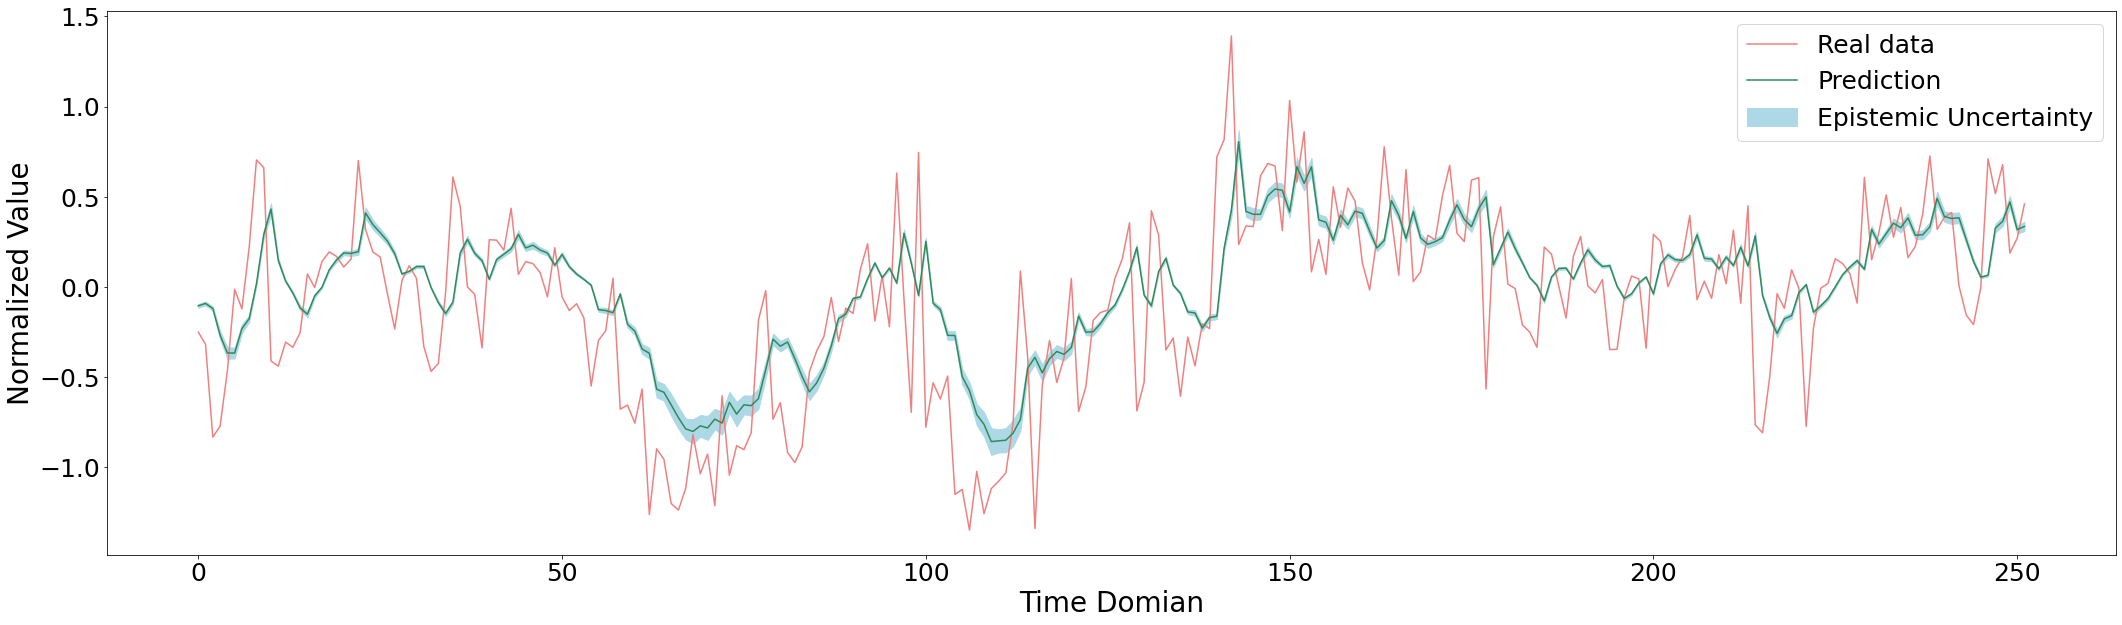

In [67]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() + 2*v**0.5, np.mean(eps, axis=0).flatten() - 2*v**0.5, color='lightblue') # plot two std (95% confidence) 
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Epistemic Uncertainty'],loc='upper right')

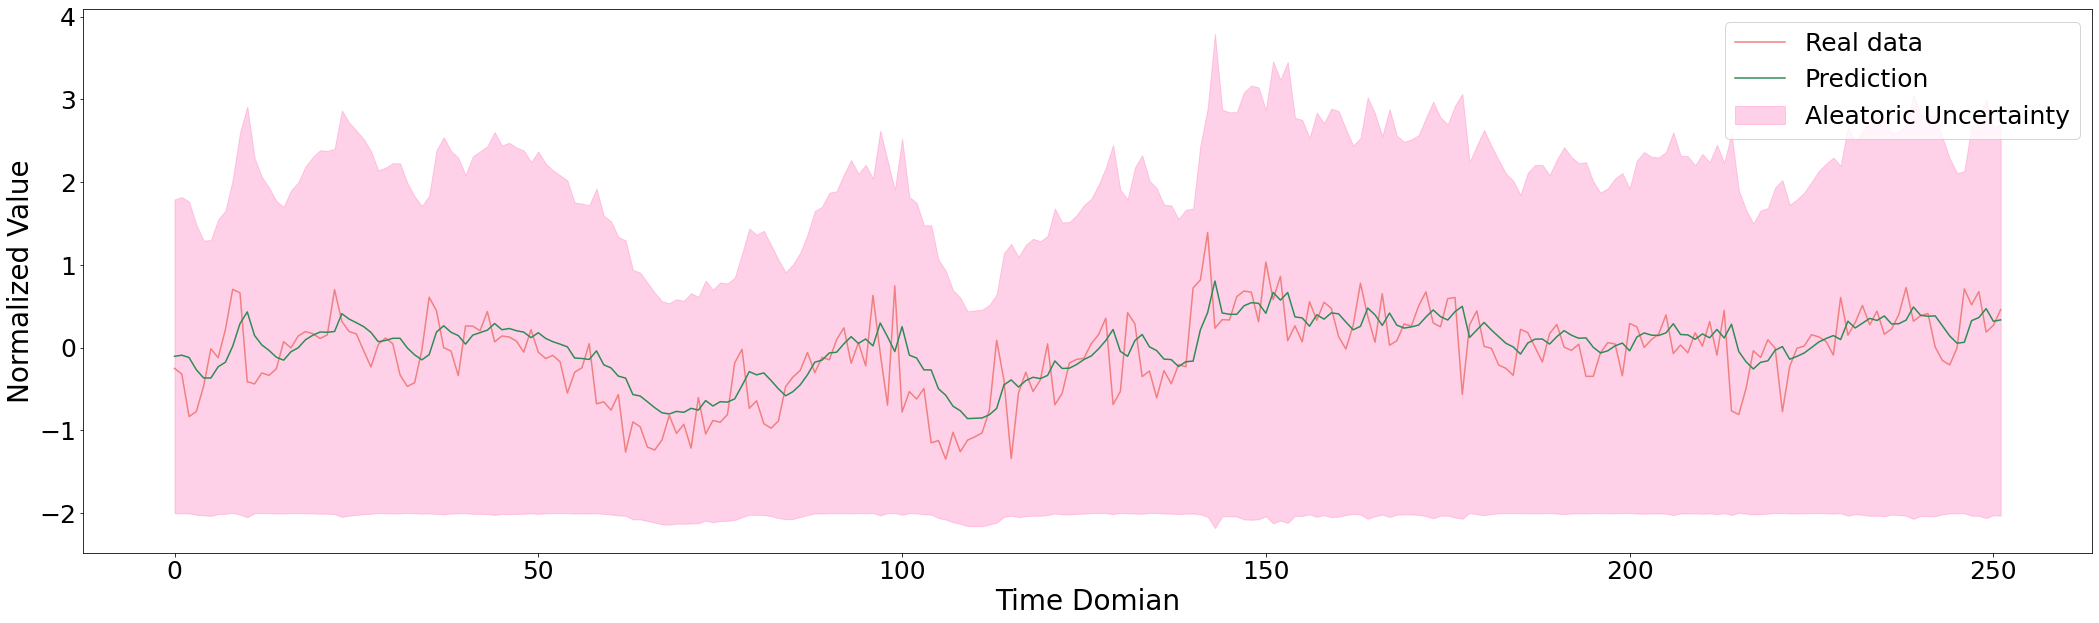

In [68]:
tx = range(len(testY))
plt.figure(figsize=(36,10))
plt.plot(tx,testY,'lightcoral')
plt.plot(tx, m, 'seagreen')
plt.fill_between(tx, np.mean(eps, axis=0).flatten() - 2*a_u**0.5, np.mean(eps, axis=0).flatten() + 2*a_u**0.5, color ='hotpink', alpha = 0.3)
plt.xlabel('Time Domian')
plt.ylabel('Normalized Value')
plt.legend(['Real data','Prediction','Aleatoric Uncertainty'],loc='upper right')